In [3]:
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np



# Get Data

In [4]:
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = '2022-08-02'

panel_data = data.DataReader(tickers,'yahoo',start_date,today)
panel_data.head(5)


Attributes    Adj Close                                               Close  \
Symbols         ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277344  2454.148438  1408.559082  1530.937988  1931.946777   
2010-01-05  1576.277344  2468.053955  1437.305054  1547.488525  1931.946777   
2010-01-06  1576.277344  2454.148438  1427.722900  1555.763916  1931.946777   
2010-01-07  1610.544189  2377.673828  1437.305054  1547.488525  1973.945557   
2010-01-08  1610.544189  2391.578613  1446.887085  1539.213135  1973.945557   

Attributes                                      High          ...     Low  \
Symbols    ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

Attributes                      Open                                   Volume  \
Symbols         JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK     ANTM.JK   
Date                                                                            
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544.0   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590.0   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328.0   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653.0   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579.0   

Attributes                                 
Symbols    ASII.JK     ICBP.JK    JSMR.JK  
Date                                       
2010-01-04    40.0  26442000.0  6978806.0  
2010-01-05    40.0  42874000.0  7988164.0  
2010-01-06    40.0  44946000.0  7538113.0  
2010-01-07    40.0  24863000.0  2048787.0  
2010-01-08    40.0  19118000.0  2441705.0  

[5 rows x 24 columns]

In [5]:
data_close = panel_data["Adj Close"]
data_close.head(5).round(2)

Symbols,ANTM.JK,ASII.JK,ICBP.JK,JSMR.JK
Date,,,,
2010-01-04,1576.28,2454.15,1408.56,1530.94
2010-01-05,1576.28,2468.05,1437.31,1547.49
2010-01-06,1576.28,2454.15,1427.72,1555.76
2010-01-07,1610.54,2377.67,1437.31,1547.49
2010-01-08,1610.54,2391.58,1446.89,1539.21


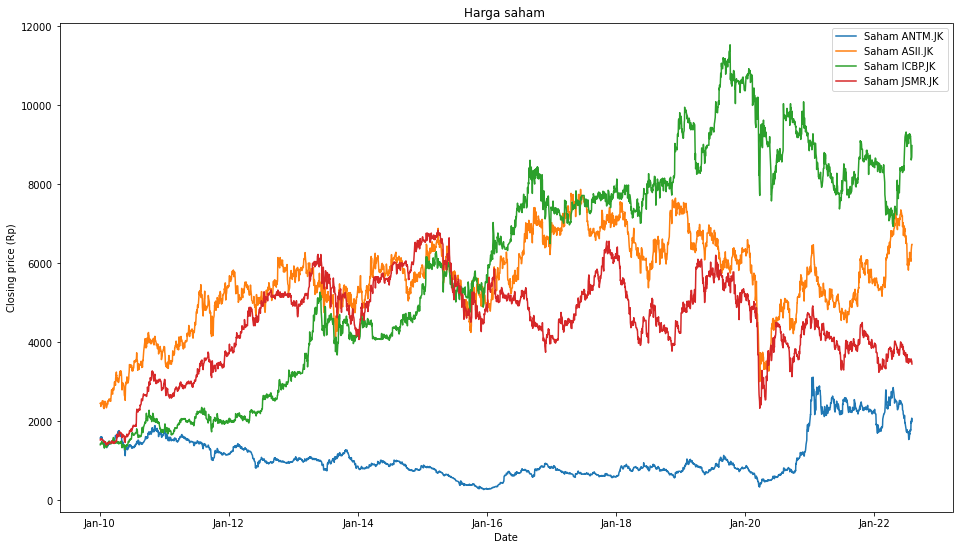

In [6]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

for name in tickers:
    ax.plot(data_close[name].index, data_close[name], label='Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

In [7]:
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close

,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1576.277344,2454.148438,1408.559082,1530.937988
2010-01-05,1576.277344,2468.053955,1437.305054,1547.488525
2010-01-06,1576.277344,2454.148438,1427.722900,1555.763916
2010-01-07,1610.544189,2377.673828,1437.305054,1547.488525
2010-01-08,1610.544189,2391.578613,1446.887085,1539.213135
...,...,...,...,...
2022-07-27,1785.000000,6100.000000,9050.941406,3510.000000
2022-07-28,2000.000000,6050.000000,8758.188477,3580.000000
2022-07-29,1955.000000,6325.000000,8611.811523,3560.000000


# Normalize Data

In [8]:
df_antm = pd.DataFrame(data_close.antm)
df_asii = pd.DataFrame(data_close.asii)
df_icbp = pd.DataFrame(data_close.icbp)
df_jsmr = pd.DataFrame(data_close.jsmr)

In [9]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_antm = pd.DataFrame(scaler.fit_transform(df_antm), columns = ['antm'])
df_asii = pd.DataFrame(scaler.fit_transform(df_asii), columns = ['asii'])
df_icbp = pd.DataFrame(scaler.fit_transform(df_icbp), columns = ['icbp'])
df_jsmr = pd.DataFrame(scaler.fit_transform(df_jsmr), columns = ['jsmr'])



## Sliding window function

In [10]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# TUNING PARAMETER

In [11]:
# from pandas import DataFrame
# from pandas import Series
# from pandas import concat
# from pandas import read_csv
# from pandas import datetime
# from math import sqrt
# import matplotlib
# import numpy
# from numpy import concatenate

# # date-time parsing function for loading the dataset
# def parser(x):
# 	return datetime.strptime('190'+x, '%Y-%m')
 

# # frame a sequence as a supervised learning problem
# def timeseries_to_supervised(data, lag=1):
# 	df = DataFrame(data)
# 	columns = [df.shift(i) for i in range(1, lag+1)]
# 	columns.append(df)
# 	df = concat(columns, axis=1)
# 	return df
 
# # create a differenced series
# def difference(dataset, interval=1):
# 	diff = list()
# 	for i in range(interval, len(dataset)):
# 		value = dataset[i] - dataset[i - interval]
# 		diff.append(value)
# 	return Series(diff)
 
# # invert differenced value
# def inverse_difference(history, yhat, interval=1):
# 	return yhat + history[-interval]
 
# # scale train and test data to [-1, 1]
# def scale(train, test):
# 	# fit scaler
# 	scaler = MinMaxScaler(feature_range=(-1, 1))
# 	scaler = scaler.fit(train)
# 	# transform train
# 	train = train.reshape(train.shape[0], train.shape[1])
# 	train_scaled = scaler.transform(train)
# 	# transform test
# 	test = test.reshape(test.shape[0], test.shape[1])
# 	test_scaled = scaler.transform(test)
# 	return scaler, train_scaled, test_scaled
 
# # inverse scaling for a forecasted value
# def invert_scale(scaler, X, yhat):
# 	new_row = [x for x in X] + [yhat]
# 	array = numpy.array(new_row)
# 	array = array.reshape(1, len(array))
# 	inverted = scaler.inverse_transform(array)
# 	return inverted[0, -1]
 
# # fit an LSTM network to training data
# def fit_lstm(train, batch_size, nb_epoch, neurons, timesteps):
# 	X, y = train[:, 0:-1], train[:, -1]
# 	X = X.reshape(X.shape[0], timesteps, 1)
# 	model = Sequential()
# 	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
# 	model.add(Dense(1))
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	for i in range(nb_epoch):
# 		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
# 		model.reset_states()
# 	return model
 
# # make a one-step forecast
# def forecast_lstm(model, batch_size, X):
# 	X = X.reshape(1, len(X), 1)
# 	yhat = model.predict(X, batch_size=batch_size)
# 	return yhat[0,0]
 
# # run a repeated experiment
# def experiment(repeats, series, timesteps):
# 	# transform data to be stationary
# 	raw_values = series.values
# 	diff_values = difference(raw_values, 1)
# 	# transform data to be supervised learning
# 	supervised = timeseries_to_supervised(diff_values, timesteps)
# 	supervised_values = supervised.values[timesteps:,:]
# 	# split data into train and test-sets
# 	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
# 	# transform the scale of the data
# 	scaler, train_scaled, test_scaled = scale(train, test)
# 	# run experiment
# 	error_scores = list()
# 	for r in range(repeats):
# 		# fit the base model
# 		lstm_model = fit_lstm(train_scaled, 1, 100, 1, timesteps)
# 		# forecast test dataset
# 		predictions = list()
# 		for i in range(len(test_scaled)):
# 			# predict
# 			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
# 			yhat = forecast_lstm(lstm_model, 1, X)
# 			# invert scaling
# 			yhat = invert_scale(scaler, X, yhat)
# 			# invert differencing
# 			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
# 			# store forecast
# 			predictions.append(yhat)
# 		# report performance
# 		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
# 		print('%d) Test RMSE: %.3f' % (r+1, rmse))
# 		error_scores.append(rmse)
# 	return error_scores
 


In [12]:
# # execute the experiment
# def run():
# 	# load dataset
# 	# experiment
# 	repeats = 2
# 	results = DataFrame()
# 	# run experiment
# 	timesteps = 1
# 	results['results'] = experiment(repeats, df_antm, timesteps)
# 	# summarize results
# 	print(results.describe())
# 	# save results
# 	results.to_csv('antm_experiment_timesteps_1.csv', index=False)
 
#  # entry point
# run()

In [13]:
# from pandas import DataFrame
# from pandas import read_csv
# from matplotlib import pyplot
# # load results into a dataframe
# filenames = ['experiment_timesteps_1.csv', 'experiment_timesteps_2.csv',
# 	'experiment_timesteps_3.csv','experiment_timesteps_4.csv','experiment_timesteps_5.csv']
# results = DataFrame()
# for name in filenames:
# 	results[name[11:-4]] = read_csv(name, header=0)
# # describe all results
# print(results.describe())
# # box and whisker plot
# results.boxplot()
# pyplot.show()

## TIMESTEPS

In [14]:
n_steps_1 = 1
n_steps_2 = 2
n_steps_3 = 3
n_steps_4 = 4
n_features = 1

### ANTM

In [15]:
df_antm = df_antm.reset_index(drop=True)
arr_antm = df_antm.to_numpy()
flat_antm = arr_antm.flatten()
antm_X_1, antm_y_1 = split_sequence(flat_antm, n_steps_1)
antm_X_2, antm_y_2 = split_sequence(flat_antm, n_steps_2)
antm_X_3, antm_y_3 = split_sequence(flat_antm, n_steps_3)
antm_X_4, antm_y_4 = split_sequence(flat_antm, n_steps_4)

In [16]:
# train test split
from sklearn.model_selection import train_test_split
X_train_antm_1, X_test_antm_1, y_train_antm_1, y_test_antm_1 = train_test_split(antm_X_1, antm_y_1, test_size=0.33, random_state=42)
X_train_antm_2, X_test_antm_2, y_train_antm_2, y_test_antm_2 = train_test_split(antm_X_2, antm_y_2, test_size=0.33, random_state=42)
X_train_antm_3, X_test_antm_3, y_train_antm_3, y_test_antm_3 = train_test_split(antm_X_3, antm_y_3, test_size=0.33, random_state=42)
X_train_antm_4, X_test_antm_4, y_train_antm_4, y_test_antm_4 = train_test_split(antm_X_4, antm_y_4, test_size=0.33, random_state=42)


In [17]:
X_train_antm_1 = X_train_antm_1.reshape(X_train_antm_1.shape[0],X_train_antm_1.shape[1],n_features)
X_test_antm_1 = X_test_antm_1.reshape(X_test_antm_1.shape[0],X_test_antm_1.shape[1],n_features)
X_train_antm_2 = X_train_antm_2.reshape(X_train_antm_2.shape[0],X_train_antm_2.shape[1],n_features)
X_test_antm_2 = X_test_antm_2.reshape(X_test_antm_2.shape[0],X_test_antm_2.shape[1],n_features)
X_train_antm_3 = X_train_antm_3.reshape(X_train_antm_3.shape[0],X_train_antm_3.shape[1],n_features)
X_test_antm_3 = X_test_antm_3.reshape(X_test_antm_3.shape[0],X_test_antm_3.shape[1],n_features)
X_train_antm_4 = X_train_antm_4.reshape(X_train_antm_4.shape[0],X_train_antm_4.shape[1],n_features)
X_test_antm_4 = X_test_antm_4.reshape(X_test_antm_4.shape[0],X_test_antm_4.shape[1],n_features)

In [18]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_antm_1 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features)),
  Dense(1),
])


simple_model_antm_1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_antm_2 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_2, n_features)),
  Dense(1),
])


simple_model_antm_2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_antm_3 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_3, n_features)),
  Dense(1),
])


simple_model_antm_3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_antm_4 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_4, n_features)),
  Dense(1),
])


simple_model_antm_4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)


In [19]:
smod_history_antm_1 = simple_model_antm_1.fit(X_train_antm_1, y_train_antm_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

# time 19.8s

Epoch 1/100
53/53 [==============================] - 2s 12ms/step - loss: 0.1469 - mae: 0.1469 - val_loss: 0.1002 - val_mae: 0.1002
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.1293 - mae: 0.1293 - val_loss: 0.0810 - val_mae: 0.0810
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.1278 - mae: 0.1278 - val_loss: 0.0666 - val_mae: 0.0666
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.1275 - mae: 0.1275 - val_loss: 0.0564 - val_mae: 0.0564
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.1278 - mae: 0.1278 - val_loss: 0.0539 - val_mae: 0.0539
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.1266 - mae: 0.1266 - val_loss: 0.0459 - val_mae: 0.0459
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.1263 - mae: 0.1263 - val_loss: 0.0434 - val_mae: 0.0434
Epoch 8/100
53/53 [==============================] - 0s 3ms/step - loss: 0.1265 - 

In [20]:
smod_history_antm_2 = simple_model_antm_2.fit(X_train_antm_2, y_train_antm_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

# time 21.9s

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.0735 - mae: 0.0735 - val_loss: 0.0174 - val_mae: 0.0174
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0125 - mae: 0.0125 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0092 - mae: 0.0092 - val_loss: 0.0124 - val_mae: 0.0124
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0097 - mae: 0.0097 - val_loss: 0.0092 - val_mae: 0.0092
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0097 - mae: 0.0097 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0104 - mae: 0.0104 - val_loss: 0.0094 - val_mae: 0.0094
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0088 - val_mae: 0.0088
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0100 - m

In [21]:
smod_history_antm_3 = simple_model_antm_3.fit(X_train_antm_3, y_train_antm_3,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 22.6

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.1429 - mae: 0.1429 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0253 - val_mae: 0.0253
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0194 - val_mae: 0.0194
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0124 - val_mae: 0.0124
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0111 - mae: 0.0111 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0103 - mae: 0.0103 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0115 - m

In [22]:
smod_history_antm_4 = simple_model_antm_4.fit(X_train_antm_4, y_train_antm_4,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 24.2s

Epoch 1/100
53/53 [==============================] - 2s 9ms/step - loss: 0.0524 - mae: 0.0524 - val_loss: 0.0161 - val_mae: 0.0161
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0157 - val_mae: 0.0157
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0116 - mae: 0.0116 - val_loss: 0.0111 - val_mae: 0.0111
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0107 - val_mae: 0.0107
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0102 - mae: 0.0102 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0106 - mae: 0.0106 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0117 - m

In [23]:
preds_antm_1 = simple_model_antm_1.predict(X_test_antm_1)
preds_antm_2 = simple_model_antm_2.predict(X_test_antm_2)
preds_antm_3 = simple_model_antm_3.predict(X_test_antm_3)
preds_antm_4 = simple_model_antm_4.predict(X_test_antm_4)

In [27]:
from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 1")
print("mae score antm_1: "+str(mean_absolute_error(preds_antm_1, y_test_antm_1)))
print("r2 score antm_1: "+str(r2_score(preds_antm_1, y_test_antm_1)))
print("mape score antm_1: "+str(mean_absolute_percentage_error(preds_antm_1, y_test_antm_1)))
print("rmse score antm_1: "+str(np.sqrt(mean_squared_error(preds_antm_1, y_test_antm_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 2")
print("mae score antm_2: "+str(mean_absolute_error(preds_antm_2, y_test_antm_2)))
print("r2 score antm_2: "+str(r2_score(preds_antm_2, y_test_antm_2)))
print("mape score antm_2: "+str(mean_absolute_percentage_error(preds_antm_2, y_test_antm_2)))
print("rmse score antm_2: "+str(np.sqrt(mean_squared_error(preds_antm_2, y_test_antm_2))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 3")
print("mae score antm_3: "+str(mean_absolute_error(preds_antm_3, y_test_antm_3)))
print("r2 score antm_3: "+str(r2_score(preds_antm_3, y_test_antm_3)))
print("mape score antm_3: "+str(mean_absolute_percentage_error(preds_antm_3, y_test_antm_3)))
print("rmse score antm_3: "+str(np.sqrt(mean_squared_error(preds_antm_3, y_test_antm_3))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 4")
print("mae score antm_4: "+str(mean_absolute_error(preds_antm_4, y_test_antm_4)))
print("r2 score antm_4: "+str(r2_score(preds_antm_4, y_test_antm_4)))
print("mape score antm_4: "+str(mean_absolute_percentage_error(preds_antm_4, y_test_antm_4)))
print("rmse score antm_4: "+str(np.sqrt(mean_squared_error(preds_antm_4, y_test_antm_4))))

mae_antm = {'timesteps_1':mean_absolute_error(preds_antm_1, y_test_antm_1),'timesteps_2':mean_absolute_error(preds_antm_2, y_test_antm_2),'timesteps_3':mean_absolute_error(preds_antm_3, y_test_antm_3),'timesteps_4':mean_absolute_error(preds_antm_4, y_test_antm_4)}

mape_antm = {'timesteps_1':mean_absolute_percentage_error(preds_antm_1, y_test_antm_1),'timesteps_2':mean_absolute_percentage_error(preds_antm_2, y_test_antm_2),'timesteps_3':mean_absolute_percentage_error(preds_antm_3, y_test_antm_3),'timesteps_4':mean_absolute_percentage_error(preds_antm_4, y_test_antm_4)}

rmse_antm = {'timesteps_1':np.sqrt(mean_squared_error(preds_antm_1, y_test_antm_1)),'timesteps_2':np.sqrt(mean_squared_error(preds_antm_2, y_test_antm_2)),'timesteps_3':np.sqrt(mean_squared_error(preds_antm_3, y_test_antm_3)),'timesteps_4':np.sqrt(mean_squared_error(preds_antm_4, y_test_antm_4))}

r2_antm = {'timesteps_1':r2_score(preds_antm_1, y_test_antm_1),'timesteps_2':r2_score(preds_antm_2, y_test_antm_2),'timesteps_3':r2_score(preds_antm_3, y_test_antm_3),'timesteps_4':r2_score(preds_antm_4, y_test_antm_4)} 


timesteps 1
mae score antm_1: 0.05351210758470884
r2 score antm_1: -0.012847259777391207
mape score antm_1: 0.17672596212047678
rmse score antm_1: 0.1109104112490807
timesteps 2
mae score antm_2: 0.008161751530795817
r2 score antm_2: 0.9952483822666641
mape score antm_2: 0.036884902423474634
rmse score antm_2: 0.013446005459325163
timesteps 3
mae score antm_3: 0.009117184707894537
r2 score antm_3: 0.9943208018711837
mape score antm_3: 0.0415330433575899
rmse score antm_3: 0.014982986270849675
timesteps 4
mae score antm_4: 0.008764602393161843
r2 score antm_4: 0.9943954589232934
mape score antm_4: 0.041414121470253945
rmse score antm_4: 0.014978998319218338


In [ ]:
# timesteps 1
# mae score antm_1: 0.05351210758470884
# r2 score antm_1: -0.012847259777391207
# mape score antm_1: 0.17672596212047678
# rmse score antm_1: 0.1109104112490807
# timesteps 2
# mae score antm_2: 0.008161751530795817
# r2 score antm_2: 0.9952483822666641
# mape score antm_2: 0.036884902423474634
# rmse score antm_2: 0.013446005459325163
# timesteps 3
# mae score antm_3: 0.009117184707894537
# r2 score antm_3: 0.9943208018711837
# mape score antm_3: 0.0415330433575899
# rmse score antm_3: 0.014982986270849675
# timesteps 4
# mae score antm_4: 0.008764602393161843
# r2 score antm_4: 0.9943954589232934
# mape score antm_4: 0.041414121470253945
# rmse score antm_4: 0.014978998319218338

In [55]:
print("sorted mae")
mae_antm_1_sorted = dict(sorted(mae_antm.items(),key=lambda item: item[1]))
print(mae_antm_1_sorted)
print("sorted rmse")
rmse_antm_sorted = dict(sorted(rmse_antm.items(),key=lambda item: item[1]))
print(rmse_antm_sorted)
print("sorted mape")
mape_antm_sorted = dict(sorted(mape_antm.items(),key=lambda item: item[1]))
print(mape_antm_sorted)
print("sorted r2")
r2_antm_sorted = dict(sorted(r2_antm.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_sorted)

sorted mae
{'timesteps_2': 0.008161751530795817, 'timesteps_4': 0.008764602393161843, 'timesteps_3': 0.009117184707894537, 'timesteps_1': 0.05351210758470884}
sorted rmse
{'timesteps_2': 0.013446005459325163, 'timesteps_4': 0.014978998319218338, 'timesteps_3': 0.014982986270849675, 'timesteps_1': 0.1109104112490807}
sorted mape
{'timesteps_2': 0.036884902423474634, 'timesteps_4': 0.041414121470253945, 'timesteps_3': 0.0415330433575899, 'timesteps_1': 0.17672596212047678}
sorted r2
{'timesteps_2': 0.9952483822666641, 'timesteps_4': 0.9943954589232934, 'timesteps_3': 0.9943208018711837, 'timesteps_1': -0.012847259777391207}


In [ ]:
# sorted mae
# {'timesteps_2': 0.008161751530795817, 'timesteps_4': 0.008764602393161843, 'timesteps_3': 0.009117184707894537, 'timesteps_1': 0.05351210758470884}
# sorted rmse
# {'timesteps_2': 0.013446005459325163, 'timesteps_4': 0.014978998319218338, 'timesteps_3': 0.014982986270849675, 'timesteps_1': 0.1109104112490807}
# sorted mape
# {'timesteps_2': 0.036884902423474634, 'timesteps_4': 0.041414121470253945, 'timesteps_3': 0.0415330433575899, 'timesteps_1': 0.17672596212047678}
# sorted r2
# {'timesteps_2': 0.9952483822666641, 'timesteps_4': 0.9943954589232934, 'timesteps_3': 0.9943208018711837, 'timesteps_1': -0.012847259777391207}

### ASII

In [56]:
df_asii = df_asii.reset_index(drop=True)
arr_asii = df_asii.to_numpy()
flat_asii = arr_asii.flatten()
asii_X_1, asii_y_1 = split_sequence(flat_asii, n_steps_1)
asii_X_2, asii_y_2 = split_sequence(flat_asii, n_steps_2)
asii_X_3, asii_y_3 = split_sequence(flat_asii, n_steps_3)
asii_X_4, asii_y_4 = split_sequence(flat_asii, n_steps_4)

# train test split
from sklearn.model_selection import train_test_split
X_train_asii_1, X_test_asii_1, y_train_asii_1, y_test_asii_1 = train_test_split(asii_X_1, asii_y_1, test_size=0.33, random_state=42)
X_train_asii_2, X_test_asii_2, y_train_asii_2, y_test_asii_2 = train_test_split(asii_X_2, asii_y_2, test_size=0.33, random_state=42)
X_train_asii_3, X_test_asii_3, y_train_asii_3, y_test_asii_3 = train_test_split(asii_X_3, asii_y_3, test_size=0.33, random_state=42)
X_train_asii_4, X_test_asii_4, y_train_asii_4, y_test_asii_4 = train_test_split(asii_X_4, asii_y_4, test_size=0.33, random_state=42)

X_train_asii_1 = X_train_asii_1.reshape(X_train_asii_1.shape[0],X_train_asii_1.shape[1],n_features)
X_test_asii_1 = X_test_asii_1.reshape(X_test_asii_1.shape[0],X_test_asii_1.shape[1],n_features)
X_train_asii_2 = X_train_asii_2.reshape(X_train_asii_2.shape[0],X_train_asii_2.shape[1],n_features)
X_test_asii_2 = X_test_asii_2.reshape(X_test_asii_2.shape[0],X_test_asii_2.shape[1],n_features)
X_train_asii_3 = X_train_asii_3.reshape(X_train_asii_3.shape[0],X_train_asii_3.shape[1],n_features)
X_test_asii_3 = X_test_asii_3.reshape(X_test_asii_3.shape[0],X_test_asii_3.shape[1],n_features)
X_train_asii_4 = X_train_asii_4.reshape(X_train_asii_4.shape[0],X_train_asii_4.shape[1],n_features)
X_test_asii_4 = X_test_asii_4.reshape(X_test_asii_4.shape[0],X_test_asii_4.shape[1],n_features)

In [57]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_asii_1 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features)),
  Dense(1),
])


simple_model_asii_1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_asii_2 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_2, n_features)),
  Dense(1),
])


simple_model_asii_2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_asii_3 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_3, n_features)),
  Dense(1),
])


simple_model_asii_3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_asii_4 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_4, n_features)),
  Dense(1),
])


simple_model_asii_4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)


In [59]:
smod_history_asii_1 = simple_model_asii_1.fit(X_train_asii_1, y_train_asii_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 19.7s

Epoch 1/100
53/53 [==============================] - 2s 10ms/step - loss: 0.2262 - mae: 0.2262 - val_loss: 0.0950 - val_mae: 0.0950
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0697 - mae: 0.0697 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0202 - val_mae: 0.0202
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0198 - val_mae: 0.0198
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0202 - val_mae: 0.0202
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0206 - val_mae: 0.0206
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0239 - 

In [60]:
smod_history_asii_2 = simple_model_asii_2.fit(X_train_asii_2, y_train_asii_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 21.7s

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.1739 - mae: 0.1739 - val_loss: 0.0439 - val_mae: 0.0439
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0185 - val_mae: 0.0185
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0183 - mae: 0.0183 - val_loss: 0.0203 - val_mae: 0.0203
Epoch 5/100
53/53 [==============================] - ETA: 0s - loss: 0.0186 - mae: 0.018 - 0s 4ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0174 - mae: 0.0174 - val_loss: 0.0211 - val_mae: 0.0211
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0198 - mae: 0.0198 - val_loss: 0.0191 - val_mae: 0.0191
Epoch 8/100
53/53 [==========================

In [61]:
smod_history_asii_3 = simple_model_asii_3.fit(X_train_asii_3, y_train_asii_3,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 23.7s

Epoch 1/100
53/53 [==============================] - 2s 10ms/step - loss: 0.1505 - mae: 0.1505 - val_loss: 0.0292 - val_mae: 0.0292
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0231 - val_mae: 0.0231
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0182 - val_mae: 0.0182
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0176 - val_mae: 0.0176
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0187 - 

In [62]:
smod_history_asii_4 = simple_model_asii_4.fit(X_train_asii_4, y_train_asii_4,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 24.6s

Epoch 1/100
53/53 [==============================] - 2s 12ms/step - loss: 0.1645 - mae: 0.1645 - val_loss: 0.0434 - val_mae: 0.0434
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0256 - val_mae: 0.0256
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0182 - val_mae: 0.0182
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0214 - 

In [63]:
preds_asii_1 = simple_model_asii_1.predict(X_test_asii_1)
preds_asii_2 = simple_model_asii_2.predict(X_test_asii_2)
preds_asii_3 = simple_model_asii_3.predict(X_test_asii_3)
preds_asii_4 = simple_model_asii_4.predict(X_test_asii_4)

In [64]:
from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 1")
print("mae score asii_1: "+str(mean_absolute_error(preds_asii_1, y_test_asii_1)))
print("r2 score asii_1: "+str(r2_score(preds_asii_1, y_test_asii_1)))
print("mape score asii_1: "+str(mean_absolute_percentage_error(preds_asii_1, y_test_asii_1)))
print("rmse score asii_1: "+str(np.sqrt(mean_squared_error(preds_asii_1, y_test_asii_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 2")
print("mae score asii_2: "+str(mean_absolute_error(preds_asii_2, y_test_asii_2)))
print("r2 score asii_2: "+str(r2_score(preds_asii_2, y_test_asii_2)))
print("mape score asii_2: "+str(mean_absolute_percentage_error(preds_asii_2, y_test_asii_2)))
print("rmse score asii_2: "+str(np.sqrt(mean_squared_error(preds_asii_2, y_test_asii_2))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 3")
print("mae score asii_3: "+str(mean_absolute_error(preds_asii_3, y_test_asii_3)))
print("r2 score asii_3: "+str(r2_score(preds_asii_3, y_test_asii_3)))
print("mape score asii_3: "+str(mean_absolute_percentage_error(preds_asii_3, y_test_asii_3)))
print("rmse score asii_3: "+str(np.sqrt(mean_squared_error(preds_asii_3, y_test_asii_3))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 4")
print("mae score asii_4: "+str(mean_absolute_error(preds_asii_4, y_test_asii_4)))
print("r2 score asii_4: "+str(r2_score(preds_asii_4, y_test_asii_4)))
print("mape score asii_4: "+str(mean_absolute_percentage_error(preds_asii_4, y_test_asii_4)))
print("rmse score asii_4: "+str(np.sqrt(mean_squared_error(preds_asii_4, y_test_asii_4))))

mae_asii = {'timesteps_1':mean_absolute_error(preds_asii_1, y_test_asii_1),'timesteps_2':mean_absolute_error(preds_asii_2, y_test_asii_2),'timesteps_3':mean_absolute_error(preds_asii_3, y_test_asii_3),'timesteps_4':mean_absolute_error(preds_asii_4, y_test_asii_4)}

mape_asii = {'timesteps_1':mean_absolute_percentage_error(preds_asii_1, y_test_asii_1),'timesteps_2':mean_absolute_percentage_error(preds_asii_2, y_test_asii_2),'timesteps_3':mean_absolute_percentage_error(preds_asii_3, y_test_asii_3),'timesteps_4':mean_absolute_percentage_error(preds_asii_4, y_test_asii_4)}

rmse_asii = {'timesteps_1':np.sqrt(mean_squared_error(preds_asii_1, y_test_asii_1)),'timesteps_2':np.sqrt(mean_squared_error(preds_asii_2, y_test_asii_2)),'timesteps_3':np.sqrt(mean_squared_error(preds_asii_3, y_test_asii_3)),'timesteps_4':np.sqrt(mean_squared_error(preds_asii_4, y_test_asii_4))}

r2_asii = {'timesteps_1':r2_score(preds_asii_1, y_test_asii_1),'timesteps_2':r2_score(preds_asii_2, y_test_asii_2),'timesteps_3':r2_score(preds_asii_3, y_test_asii_3),'timesteps_4':r2_score(preds_asii_4, y_test_asii_4)} 



timesteps 1
mae score asii_1: 0.015697579842078434
r2 score asii_1: 0.9891798496508
mape score asii_1: 0.03516537230185299
rmse score asii_1: 0.02077293181651314
timesteps 2
mae score asii_2: 0.015313086808529379
r2 score asii_2: 0.9900058330429263
mape score asii_2: 0.05661475089706797
rmse score asii_2: 0.020241523730058424
timesteps 3
mae score asii_3: 0.01468973459169929
r2 score asii_3: 0.9901866526074022
mape score asii_3: 0.0329870319926044
rmse score asii_3: 0.019597623902703688
timesteps 4
mae score asii_4: 0.015275431236995839
r2 score asii_4: 0.9896423031917067
mape score asii_4: 0.04428520573595462
rmse score asii_4: 0.020267971711778642


In [ ]:
# timesteps 1
# mae score asii_1: 0.015697579842078434
# r2 score asii_1: 0.9891798496508
# mape score asii_1: 0.03516537230185299
# rmse score asii_1: 0.02077293181651314
# timesteps 2
# mae score asii_2: 0.015313086808529379
# r2 score asii_2: 0.9900058330429263
# mape score asii_2: 0.05661475089706797
# rmse score asii_2: 0.020241523730058424
# timesteps 3
# mae score asii_3: 0.01468973459169929
# r2 score asii_3: 0.9901866526074022
# mape score asii_3: 0.0329870319926044
# rmse score asii_3: 0.019597623902703688
# timesteps 4
# mae score asii_4: 0.015275431236995839
# r2 score asii_4: 0.9896423031917067
# mape score asii_4: 0.04428520573595462
# rmse score asii_4: 0.020267971711778642

In [65]:
print("sorted mae")
mae_asii_1_sorted = dict(sorted(mae_asii.items(),key=lambda item: item[1]))
print(mae_asii_1_sorted)
print("sorted rmse")
rmse_asii_sorted = dict(sorted(rmse_asii.items(),key=lambda item: item[1]))
print(rmse_asii_sorted)
print("sorted mape")
mape_asii_sorted = dict(sorted(mape_asii.items(),key=lambda item: item[1]))
print(mape_asii_sorted)
print("sorted r2")
r2_asii_sorted = dict(sorted(r2_asii.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted)

sorted mae
{'timesteps_3': 0.01468973459169929, 'timesteps_4': 0.015275431236995839, 'timesteps_2': 0.015313086808529379, 'timesteps_1': 0.015697579842078434}
sorted rmse
{'timesteps_3': 0.019597623902703688, 'timesteps_2': 0.020241523730058424, 'timesteps_4': 0.020267971711778642, 'timesteps_1': 0.02077293181651314}
sorted mape
{'timesteps_3': 0.0329870319926044, 'timesteps_1': 0.03516537230185299, 'timesteps_4': 0.04428520573595462, 'timesteps_2': 0.05661475089706797}
sorted r2
{'timesteps_3': 0.9901866526074022, 'timesteps_2': 0.9900058330429263, 'timesteps_4': 0.9896423031917067, 'timesteps_1': 0.9891798496508}


In [ ]:
# sorted mae
# {'timesteps_3': 0.01468973459169929, 'timesteps_4': 0.015275431236995839, 'timesteps_2': 0.015313086808529379, 'timesteps_1': 0.015697579842078434}
# sorted rmse
# {'timesteps_3': 0.019597623902703688, 'timesteps_2': 0.020241523730058424, 'timesteps_4': 0.020267971711778642, 'timesteps_1': 0.02077293181651314}
# sorted mape
# {'timesteps_3': 0.0329870319926044, 'timesteps_1': 0.03516537230185299, 'timesteps_4': 0.04428520573595462, 'timesteps_2': 0.05661475089706797}
# sorted r2
# {'timesteps_3': 0.9901866526074022, 'timesteps_2': 0.9900058330429263, 'timesteps_4': 0.9896423031917067, 'timesteps_1': 0.9891798496508}

### ICBP

In [66]:
df_icbp = df_icbp.reset_index(drop=True)
arr_icbp = df_icbp.to_numpy()
flat_icbp = arr_icbp.flatten()
icbp_X_1, icbp_y_1 = split_sequence(flat_icbp, n_steps_1)
icbp_X_2, icbp_y_2 = split_sequence(flat_icbp, n_steps_2)
icbp_X_3, icbp_y_3 = split_sequence(flat_icbp, n_steps_3)
icbp_X_4, icbp_y_4 = split_sequence(flat_icbp, n_steps_4)

# train test split
from sklearn.model_selection import train_test_split
X_train_icbp_1, X_test_icbp_1, y_train_icbp_1, y_test_icbp_1 = train_test_split(icbp_X_1, icbp_y_1, test_size=0.33, random_state=42)
X_train_icbp_2, X_test_icbp_2, y_train_icbp_2, y_test_icbp_2 = train_test_split(icbp_X_2, icbp_y_2, test_size=0.33, random_state=42)
X_train_icbp_3, X_test_icbp_3, y_train_icbp_3, y_test_icbp_3 = train_test_split(icbp_X_3, icbp_y_3, test_size=0.33, random_state=42)
X_train_icbp_4, X_test_icbp_4, y_train_icbp_4, y_test_icbp_4 = train_test_split(icbp_X_4, icbp_y_4, test_size=0.33, random_state=42)

X_train_icbp_1 = X_train_icbp_1.reshape(X_train_icbp_1.shape[0],X_train_icbp_1.shape[1],n_features)
X_test_icbp_1 = X_test_icbp_1.reshape(X_test_icbp_1.shape[0],X_test_icbp_1.shape[1],n_features)
X_train_icbp_2 = X_train_icbp_2.reshape(X_train_icbp_2.shape[0],X_train_icbp_2.shape[1],n_features)
X_test_icbp_2 = X_test_icbp_2.reshape(X_test_icbp_2.shape[0],X_test_icbp_2.shape[1],n_features)
X_train_icbp_3 = X_train_icbp_3.reshape(X_train_icbp_3.shape[0],X_train_icbp_3.shape[1],n_features)
X_test_icbp_3 = X_test_icbp_3.reshape(X_test_icbp_3.shape[0],X_test_icbp_3.shape[1],n_features)
X_train_icbp_4 = X_train_icbp_4.reshape(X_train_icbp_4.shape[0],X_train_icbp_4.shape[1],n_features)
X_test_icbp_4 = X_test_icbp_4.reshape(X_test_icbp_4.shape[0],X_test_icbp_4.shape[1],n_features)

In [67]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_icbp_1 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features)),
  Dense(1),
])


simple_model_icbp_1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_icbp_2 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_2, n_features)),
  Dense(1),
])


simple_model_icbp_2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_icbp_3 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_3, n_features)),
  Dense(1),
])


simple_model_icbp_3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_icbp_4 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_4, n_features)),
  Dense(1),
])


simple_model_icbp_4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)


In [68]:
smod_history_icbp_1 = simple_model_icbp_1.fit(X_train_icbp_1, y_train_icbp_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 19.8s

Epoch 1/100
53/53 [==============================] - 3s 10ms/step - loss: 0.1810 - mae: 0.1810 - val_loss: 0.0728 - val_mae: 0.0728
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0219 - val_mae: 0.0219
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0201 - mae: 0.0201 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0125 - val_mae: 0.0125
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0090 - mae: 0.0090 - val_loss: 0.0094 - val_mae: 0.0094
Epoch 8/100
53/53 [==============================] - ETA: 0s - loss: 0.0092 - mae:

In [69]:
smod_history_icbp_2 = simple_model_icbp_2.fit(X_train_icbp_2, y_train_icbp_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 19.6s

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.2130 - mae: 0.2130 - val_loss: 0.0298 - val_mae: 0.0298
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0136 - val_mae: 0.0136
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0090 - val_mae: 0.0090
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0099 - mae: 0.0099 - val_loss: 0.0088 - val_mae: 0.0088
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0076 - val_mae: 0.0076
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0099 - mae: 0.0099 - val_loss: 0.0086 - val_mae: 0.0086
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0091 - mae: 0.0091 - val_loss: 0.0073 - val_mae: 0.0073
Epoch 8/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0102 - m

In [70]:
smod_history_icbp_3 = simple_model_icbp_3.fit(X_train_icbp_3, y_train_icbp_3,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 23.5s

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.1949 - mae: 0.1949 - val_loss: 0.0303 - val_mae: 0.0303
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0090 - val_mae: 0.0090
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0102 - mae: 0.0102 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0102 - val_mae: 0.0102
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0095 - val_mae: 0.0095
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0102 - m

In [71]:
smod_history_icbp_4 = simple_model_icbp_4.fit(X_train_icbp_4, y_train_icbp_4,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 24.8s

Epoch 1/100
53/53 [==============================] - 2s 10ms/step - loss: 0.3389 - mae: 0.3389 - val_loss: 0.2400 - val_mae: 0.2400
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2422 - mae: 0.2422 - val_loss: 0.2267 - val_mae: 0.2267
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2394 - mae: 0.2394 - val_loss: 0.2254 - val_mae: 0.2254
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2395 - mae: 0.2395 - val_loss: 0.2253 - val_mae: 0.2253
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2398 - mae: 0.2398 - val_loss: 0.2254 - val_mae: 0.2254
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2396 - mae: 0.2396 - val_loss: 0.2250 - val_mae: 0.2250
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2399 - mae: 0.2399 - val_loss: 0.2246 - val_mae: 0.2246
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2397 - 

In [72]:
preds_icbp_1 = simple_model_icbp_1.predict(X_test_icbp_1)
preds_icbp_2 = simple_model_icbp_2.predict(X_test_icbp_2)
preds_icbp_3 = simple_model_icbp_3.predict(X_test_icbp_3)
preds_icbp_4 = simple_model_icbp_4.predict(X_test_icbp_4)

In [73]:
from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 1")
print("mae score icbp_1: "+str(mean_absolute_error(preds_icbp_1, y_test_icbp_1)))
print("r2 score icbp_1: "+str(r2_score(preds_icbp_1, y_test_icbp_1)))
print("mape score icbp_1: "+str(mean_absolute_percentage_error(preds_icbp_1, y_test_icbp_1)))
print("rmse score icbp_1: "+str(np.sqrt(mean_squared_error(preds_icbp_1, y_test_icbp_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 2")
print("mae score icbp_2: "+str(mean_absolute_error(preds_icbp_2, y_test_icbp_2)))
print("r2 score icbp_2: "+str(r2_score(preds_icbp_2, y_test_icbp_2)))
print("mape score icbp_2: "+str(mean_absolute_percentage_error(preds_icbp_2, y_test_icbp_2)))
print("rmse score icbp_2: "+str(np.sqrt(mean_squared_error(preds_icbp_2, y_test_icbp_2))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 3")
print("mae score icbp_3: "+str(mean_absolute_error(preds_icbp_3, y_test_icbp_3)))
print("r2 score icbp_3: "+str(r2_score(preds_icbp_3, y_test_icbp_3)))
print("mape score icbp_3: "+str(mean_absolute_percentage_error(preds_icbp_3, y_test_icbp_3)))
print("rmse score icbp_3: "+str(np.sqrt(mean_squared_error(preds_icbp_3, y_test_icbp_3))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 4")
print("mae score icbp_4: "+str(mean_absolute_error(preds_icbp_4, y_test_icbp_4)))
print("r2 score icbp_4: "+str(r2_score(preds_icbp_4, y_test_icbp_4)))
print("mape score icbp_4: "+str(mean_absolute_percentage_error(preds_icbp_4, y_test_icbp_4)))
print("rmse score icbp_4: "+str(np.sqrt(mean_squared_error(preds_icbp_4, y_test_icbp_4))))

mae_icbp = {'timesteps_1':mean_absolute_error(preds_icbp_1, y_test_icbp_1),'timesteps_2':mean_absolute_error(preds_icbp_2, y_test_icbp_2),'timesteps_3':mean_absolute_error(preds_icbp_3, y_test_icbp_3),'timesteps_4':mean_absolute_error(preds_icbp_4, y_test_icbp_4)}

mape_icbp = {'timesteps_1':mean_absolute_percentage_error(preds_icbp_1, y_test_icbp_1),'timesteps_2':mean_absolute_percentage_error(preds_icbp_2, y_test_icbp_2),'timesteps_3':mean_absolute_percentage_error(preds_icbp_3, y_test_icbp_3),'timesteps_4':mean_absolute_percentage_error(preds_icbp_4, y_test_icbp_4)}

rmse_icbp = {'timesteps_1':np.sqrt(mean_squared_error(preds_icbp_1, y_test_icbp_1)),'timesteps_2':np.sqrt(mean_squared_error(preds_icbp_2, y_test_icbp_2)),'timesteps_3':np.sqrt(mean_squared_error(preds_icbp_3, y_test_icbp_3)),'timesteps_4':np.sqrt(mean_squared_error(preds_icbp_4, y_test_icbp_4))}

r2_icbp = {'timesteps_1':r2_score(preds_icbp_1, y_test_icbp_1),'timesteps_2':r2_score(preds_icbp_2, y_test_icbp_2),'timesteps_3':r2_score(preds_icbp_3, y_test_icbp_3),'timesteps_4':r2_score(preds_icbp_4, y_test_icbp_4)} 



timesteps 1
mae score icbp_1: 0.0071951216005588505
r2 score icbp_1: 0.9982912893287746
mape score icbp_1: 0.02911766342732286
rmse score icbp_1: 0.0115991115450196
timesteps 2
mae score icbp_2: 0.00874996393974662
r2 score icbp_2: 0.998219167116058
mape score icbp_2: 0.10803360291602122
rmse score icbp_2: 0.011925892437280167
timesteps 3
mae score icbp_3: 0.009715755021447626
r2 score icbp_3: 0.9975988977109971
mape score icbp_3: 0.03398883492185345
rmse score icbp_3: 0.013880861676693924
timesteps 4
mae score icbp_4: 0.24760012053707564
r2 score icbp_4: 0.0
mape score icbp_4: 0.46217821589569885
rmse score icbp_4: 0.2913636094589231


In [ ]:
# timesteps 1
# mae score icbp_1: 0.0071951216005588505
# r2 score icbp_1: 0.9982912893287746
# mape score icbp_1: 0.02911766342732286
# rmse score icbp_1: 0.0115991115450196
# timesteps 2
# mae score icbp_2: 0.00874996393974662
# r2 score icbp_2: 0.998219167116058
# mape score icbp_2: 0.10803360291602122
# rmse score icbp_2: 0.011925892437280167
# timesteps 3
# mae score icbp_3: 0.009715755021447626
# r2 score icbp_3: 0.9975988977109971
# mape score icbp_3: 0.03398883492185345
# rmse score icbp_3: 0.013880861676693924
# timesteps 4
# mae score icbp_4: 0.24760012053707564
# r2 score icbp_4: 0.0
# mape score icbp_4: 0.46217821589569885
# rmse score icbp_4: 0.2913636094589231

In [74]:
print("sorted mae")
mae_icbp_1_sorted = dict(sorted(mae_icbp.items(),key=lambda item: item[1]))
print(mae_icbp_1_sorted)
print("sorted rmse")
rmse_icbp_sorted = dict(sorted(rmse_icbp.items(),key=lambda item: item[1]))
print(rmse_icbp_sorted)
print("sorted mape")
mape_icbp_sorted = dict(sorted(mape_icbp.items(),key=lambda item: item[1]))
print(mape_icbp_sorted)
print("sorted r2")
r2_icbp_sorted = dict(sorted(r2_icbp.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_sorted)

sorted mae
{'timesteps_1': 0.0071951216005588505, 'timesteps_2': 0.00874996393974662, 'timesteps_3': 0.009715755021447626, 'timesteps_4': 0.24760012053707564}
sorted rmse
{'timesteps_1': 0.0115991115450196, 'timesteps_2': 0.011925892437280167, 'timesteps_3': 0.013880861676693924, 'timesteps_4': 0.2913636094589231}
sorted mape
{'timesteps_1': 0.02911766342732286, 'timesteps_3': 0.03398883492185345, 'timesteps_2': 0.10803360291602122, 'timesteps_4': 0.46217821589569885}
sorted r2
{'timesteps_1': 0.9982912893287746, 'timesteps_2': 0.998219167116058, 'timesteps_3': 0.9975988977109971, 'timesteps_4': 0.0}


In [ ]:
# sorted mae
# {'timesteps_1': 0.0071951216005588505, 'timesteps_2': 0.00874996393974662, 'timesteps_3': 0.009715755021447626, 'timesteps_4': 0.24760012053707564}
# sorted rmse
# {'timesteps_1': 0.0115991115450196, 'timesteps_2': 0.011925892437280167, 'timesteps_3': 0.013880861676693924, 'timesteps_4': 0.2913636094589231}
# sorted mape
# {'timesteps_1': 0.02911766342732286, 'timesteps_3': 0.03398883492185345, 'timesteps_2': 0.10803360291602122, 'timesteps_4': 0.46217821589569885}
# sorted r2
# {'timesteps_1': 0.9982912893287746, 'timesteps_2': 0.998219167116058, 'timesteps_3': 0.9975988977109971, 'timesteps_4': 0.0}

### JSMR

In [75]:
df_jsmr = df_jsmr.reset_index(drop=True)
arr_jsmr = df_jsmr.to_numpy()
flat_jsmr = arr_jsmr.flatten()
jsmr_X_1, jsmr_y_1 = split_sequence(flat_jsmr, n_steps_1)
jsmr_X_2, jsmr_y_2 = split_sequence(flat_jsmr, n_steps_2)
jsmr_X_3, jsmr_y_3 = split_sequence(flat_jsmr, n_steps_3)
jsmr_X_4, jsmr_y_4 = split_sequence(flat_jsmr, n_steps_4)

# train test split
from sklearn.model_selection import train_test_split
X_train_jsmr_1, X_test_jsmr_1, y_train_jsmr_1, y_test_jsmr_1 = train_test_split(jsmr_X_1, jsmr_y_1, test_size=0.33, random_state=42)
X_train_jsmr_2, X_test_jsmr_2, y_train_jsmr_2, y_test_jsmr_2 = train_test_split(jsmr_X_2, jsmr_y_2, test_size=0.33, random_state=42)
X_train_jsmr_3, X_test_jsmr_3, y_train_jsmr_3, y_test_jsmr_3 = train_test_split(jsmr_X_3, jsmr_y_3, test_size=0.33, random_state=42)
X_train_jsmr_4, X_test_jsmr_4, y_train_jsmr_4, y_test_jsmr_4 = train_test_split(jsmr_X_4, jsmr_y_4, test_size=0.33, random_state=42)

X_train_jsmr_1 = X_train_jsmr_1.reshape(X_train_jsmr_1.shape[0],X_train_jsmr_1.shape[1],n_features)
X_test_jsmr_1 = X_test_jsmr_1.reshape(X_test_jsmr_1.shape[0],X_test_jsmr_1.shape[1],n_features)
X_train_jsmr_2 = X_train_jsmr_2.reshape(X_train_jsmr_2.shape[0],X_train_jsmr_2.shape[1],n_features)
X_test_jsmr_2 = X_test_jsmr_2.reshape(X_test_jsmr_2.shape[0],X_test_jsmr_2.shape[1],n_features)
X_train_jsmr_3 = X_train_jsmr_3.reshape(X_train_jsmr_3.shape[0],X_train_jsmr_3.shape[1],n_features)
X_test_jsmr_3 = X_test_jsmr_3.reshape(X_test_jsmr_3.shape[0],X_test_jsmr_3.shape[1],n_features)
X_train_jsmr_4 = X_train_jsmr_4.reshape(X_train_jsmr_4.shape[0],X_train_jsmr_4.shape[1],n_features)
X_test_jsmr_4 = X_test_jsmr_4.reshape(X_test_jsmr_4.shape[0],X_test_jsmr_4.shape[1],n_features)

In [76]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_jsmr_1 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features)),
  Dense(1),
])


simple_model_jsmr_1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_jsmr_2 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_2, n_features)),
  Dense(1),
])


simple_model_jsmr_2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_jsmr_3 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_3, n_features)),
  Dense(1),
])


simple_model_jsmr_3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_jsmr_4 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_4, n_features)),
  Dense(1),
])


simple_model_jsmr_4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)


In [77]:
smod_history_jsmr_1 = simple_model_jsmr_1.fit(X_train_jsmr_1, y_train_jsmr_1,
          validation_split=0.1,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 20.9s

Epoch 1/100
59/59 [==============================] - 2s 10ms/step - loss: 0.2222 - mae: 0.2222 - val_loss: 0.0803 - val_mae: 0.0803
Epoch 2/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0613 - mae: 0.0613 - val_loss: 0.0213 - val_mae: 0.0213
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0216 - val_mae: 0.0216
Epoch 4/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 5/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 6/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0174 - val_mae: 0.0174
Epoch 7/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0205 - mae: 0.0205 - val_loss: 0.0176 - val_mae: 0.0176
Epoch 8/100
59/59 [==============================] - 0s 3ms/step - loss: 0.0204 - 

In [78]:
smod_history_jsmr_2 = simple_model_jsmr_2.fit(X_train_jsmr_2, y_train_jsmr_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 18.7s

Epoch 1/100
53/53 [==============================] - 2s 7ms/step - loss: 0.1468 - mae: 0.1468 - val_loss: 0.0530 - val_mae: 0.0530
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0221 - val_mae: 0.0221
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0182 - val_mae: 0.0182
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0186 - val_mae: 0.0186
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0207 - val_mae: 0.0207
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0232 - val_mae: 0.0232
Epoch 8/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0173 - m

In [79]:
smod_history_jsmr_3 = simple_model_jsmr_3.fit(X_train_jsmr_3, y_train_jsmr_3,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 20.3s

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.1130 - mae: 0.1130 - val_loss: 0.0207 - val_mae: 0.0207
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0232 - val_mae: 0.0232
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0190 - val_mae: 0.0190
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0187 - val_mae: 0.0187
Epoch 8/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0155 - m

In [80]:
smod_history_jsmr_4 = simple_model_jsmr_4.fit(X_train_jsmr_4, y_train_jsmr_4,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 21.6s

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.2701 - mae: 0.2701 - val_loss: 0.1021 - val_mae: 0.1021
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0725 - mae: 0.0725 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0306 - val_mae: 0.0306
Epoch 4/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0271 - val_mae: 0.0271
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0253 - val_mae: 0.0253
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0284 - val_mae: 0.0284
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0222 - val_mae: 0.0222
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0216 - m

In [81]:
preds_jsmr_1 = simple_model_jsmr_1.predict(X_test_jsmr_1)
preds_jsmr_2 = simple_model_jsmr_2.predict(X_test_jsmr_2)
preds_jsmr_3 = simple_model_jsmr_3.predict(X_test_jsmr_3)
preds_jsmr_4 = simple_model_jsmr_4.predict(X_test_jsmr_4)

In [82]:
from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 1")
print("mae score jsmr_1: "+str(mean_absolute_error(preds_jsmr_1, y_test_jsmr_1)))
print("r2 score jsmr_1: "+str(r2_score(preds_jsmr_1, y_test_jsmr_1)))
print("mape score jsmr_1: "+str(mean_absolute_percentage_error(preds_jsmr_1, y_test_jsmr_1)))
print("rmse score jsmr_1: "+str(np.sqrt(mean_squared_error(preds_jsmr_1, y_test_jsmr_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 2")
print("mae score jsmr_2: "+str(mean_absolute_error(preds_jsmr_2, y_test_jsmr_2)))
print("r2 score jsmr_2: "+str(r2_score(preds_jsmr_2, y_test_jsmr_2)))
print("mape score jsmr_2: "+str(mean_absolute_percentage_error(preds_jsmr_2, y_test_jsmr_2)))
print("rmse score jsmr_2: "+str(np.sqrt(mean_squared_error(preds_jsmr_2, y_test_jsmr_2))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 3")
print("mae score jsmr_3: "+str(mean_absolute_error(preds_jsmr_3, y_test_jsmr_3)))
print("r2 score jsmr_3: "+str(r2_score(preds_jsmr_3, y_test_jsmr_3)))
print("mape score jsmr_3: "+str(mean_absolute_percentage_error(preds_jsmr_3, y_test_jsmr_3)))
print("rmse score jsmr_3: "+str(np.sqrt(mean_squared_error(preds_jsmr_3, y_test_jsmr_3))))

from sklearn.metrics import mean_absolute_percentage_error
print("timesteps 4")
print("mae score jsmr_4: "+str(mean_absolute_error(preds_jsmr_4, y_test_jsmr_4)))
print("r2 score jsmr_4: "+str(r2_score(preds_jsmr_4, y_test_jsmr_4)))
print("mape score jsmr_4: "+str(mean_absolute_percentage_error(preds_jsmr_4, y_test_jsmr_4)))
print("rmse score jsmr_4: "+str(np.sqrt(mean_squared_error(preds_jsmr_4, y_test_jsmr_4))))

mae_jsmr = {'timesteps_1':mean_absolute_error(preds_jsmr_1, y_test_jsmr_1),'timesteps_2':mean_absolute_error(preds_jsmr_2, y_test_jsmr_2),'timesteps_3':mean_absolute_error(preds_jsmr_3, y_test_jsmr_3),'timesteps_4':mean_absolute_error(preds_jsmr_4, y_test_jsmr_4)}

mape_jsmr = {'timesteps_1':mean_absolute_percentage_error(preds_jsmr_1, y_test_jsmr_1),'timesteps_2':mean_absolute_percentage_error(preds_jsmr_2, y_test_jsmr_2),'timesteps_3':mean_absolute_percentage_error(preds_jsmr_3, y_test_jsmr_3),'timesteps_4':mean_absolute_percentage_error(preds_jsmr_4, y_test_jsmr_4)}

rmse_jsmr = {'timesteps_1':np.sqrt(mean_squared_error(preds_jsmr_1, y_test_jsmr_1)),'timesteps_2':np.sqrt(mean_squared_error(preds_jsmr_2, y_test_jsmr_2)),'timesteps_3':np.sqrt(mean_squared_error(preds_jsmr_3, y_test_jsmr_3)),'timesteps_4':np.sqrt(mean_squared_error(preds_jsmr_4, y_test_jsmr_4))}

r2_jsmr = {'timesteps_1':r2_score(preds_jsmr_1, y_test_jsmr_1),'timesteps_2':r2_score(preds_jsmr_2, y_test_jsmr_2),'timesteps_3':r2_score(preds_jsmr_3, y_test_jsmr_3),'timesteps_4':r2_score(preds_jsmr_4, y_test_jsmr_4)} 



timesteps 1
mae score jsmr_1: 0.012709409360352766
r2 score jsmr_1: 0.9935702374781473
mape score jsmr_1: 0.030344619679000352
rmse score jsmr_1: 0.017236430432879077
timesteps 2
mae score jsmr_2: 0.014326228000078446
r2 score jsmr_2: 0.9923649299409023
mape score jsmr_2: 0.03485906558726514
rmse score jsmr_2: 0.018798476996323747
timesteps 3
mae score jsmr_3: 0.013212442520124074
r2 score jsmr_3: 0.9929662622837995
mape score jsmr_3: 0.04070394123414279
rmse score jsmr_3: 0.017914216506633596
timesteps 4
mae score jsmr_4: 0.012534012823066423
r2 score jsmr_4: 0.9933026921297792
mape score jsmr_4: 0.029484858211290245
rmse score jsmr_4: 0.01756805243763662


In [ ]:
# timesteps 1
# mae score jsmr_1: 0.012709409360352766
# r2 score jsmr_1: 0.9935702374781473
# mape score jsmr_1: 0.030344619679000352
# rmse score jsmr_1: 0.017236430432879077
# timesteps 2
# mae score jsmr_2: 0.014326228000078446
# r2 score jsmr_2: 0.9923649299409023
# mape score jsmr_2: 0.03485906558726514
# rmse score jsmr_2: 0.018798476996323747
# timesteps 3
# mae score jsmr_3: 0.013212442520124074
# r2 score jsmr_3: 0.9929662622837995
# mape score jsmr_3: 0.04070394123414279
# rmse score jsmr_3: 0.017914216506633596
# timesteps 4
# mae score jsmr_4: 0.012534012823066423
# r2 score jsmr_4: 0.9933026921297792
# mape score jsmr_4: 0.029484858211290245
# rmse score jsmr_4: 0.01756805243763662

In [84]:
print("sorted mae")
mae_jsmr_1_sorted = dict(sorted(mae_jsmr.items(),key=lambda item: item[1]))
print(mae_jsmr_1_sorted)
print("sorted rmse")
rmse_jsmr_sorted = dict(sorted(rmse_jsmr.items(),key=lambda item: item[1]))
print(rmse_jsmr_sorted)
print("sorted mape")
mape_jsmr_sorted = dict(sorted(mape_jsmr.items(),key=lambda item: item[1]))
print(mape_jsmr_sorted)
print("sorted r2")
r2_jsmr_sorted = dict(sorted(r2_jsmr.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_sorted)

sorted mae
{'timesteps_4': 0.012534012823066423, 'timesteps_1': 0.012709409360352766, 'timesteps_3': 0.013212442520124074, 'timesteps_2': 0.014326228000078446}
sorted rmse
{'timesteps_1': 0.017236430432879077, 'timesteps_4': 0.01756805243763662, 'timesteps_3': 0.017914216506633596, 'timesteps_2': 0.018798476996323747}
sorted mape
{'timesteps_4': 0.029484858211290245, 'timesteps_1': 0.030344619679000352, 'timesteps_2': 0.03485906558726514, 'timesteps_3': 0.04070394123414279}
sorted r2
{'timesteps_1': 0.9935702374781473, 'timesteps_4': 0.9933026921297792, 'timesteps_3': 0.9929662622837995, 'timesteps_2': 0.9923649299409023}


In [ ]:
# sorted mae
# {'timesteps_4': 0.012534012823066423, 'timesteps_1': 0.012709409360352766, 'timesteps_3': 0.013212442520124074, 'timesteps_2': 0.014326228000078446}
# sorted rmse
# {'timesteps_1': 0.017236430432879077, 'timesteps_4': 0.01756805243763662, 'timesteps_3': 0.017914216506633596, 'timesteps_2': 0.018798476996323747}
# sorted mape
# {'timesteps_4': 0.029484858211290245, 'timesteps_1': 0.030344619679000352, 'timesteps_2': 0.03485906558726514, 'timesteps_3': 0.04070394123414279}
# sorted r2
# {'timesteps_1': 0.9935702374781473, 'timesteps_4': 0.9933026921297792, 'timesteps_3': 0.9929662622837995, 'timesteps_2': 0.9923649299409023}

## Kesimpulan hasil tuning timestep
hasil tuning timestep diatas untuk keempat saham yang digunakan,
ANTM 2 timestep
ASII 3 timestep
ICBP 1 timestep
JSMR 1 atau 4 timestep

keempat saham menunjukan hasil berbeda untuk tuning timesteps ini. untuk JSMR 1 timesteps memberikan hasil terbaik pada matriks RMSE dan R2 sedangkan 4 timestep memberikan hasil terbaik pada MAE dan MAPE

## HIDDEN LAYER

### ANTM

In [104]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_antm_n2_h1 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_2, n_features)),
  Dense(1),
])


simple_model_antm_n2_h1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_antm_n2_h1.summary()


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 8)                 320       
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [105]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_antm_n2_h2 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_2, n_features),return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_antm_n2_h2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_antm_n2_h2.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 2, 8)              320       
                                                                 
 lstm_39 (LSTM)              (None, 8)                 544       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


In [106]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_antm_n2_h3 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_2, n_features),return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_antm_n2_h3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_antm_n2_h3.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 2, 8)              320       
                                                                 
 lstm_41 (LSTM)              (None, 2, 8)              544       
                                                                 
 lstm_42 (LSTM)              (None, 8)                 544       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [107]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_antm_n2_h4 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_2, n_features),return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_antm_n2_h4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_antm_n2_h4.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 2, 8)              320       
                                                                 
 lstm_44 (LSTM)              (None, 2, 8)              544       
                                                                 
 lstm_45 (LSTM)              (None, 2, 8)              544       
                                                                 
 lstm_46 (LSTM)              (None, 8)                 544       
                                                                 
 dense_28 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [108]:
smod_history_antm_n2_h1 = simple_model_antm_n2_h1.fit(X_train_antm_2, y_train_antm_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)
#time 21.5

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.1521 - mae: 0.1521 - val_loss: 0.1064 - val_mae: 0.1064
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0438 - mae: 0.0438 - val_loss: 0.0207 - val_mae: 0.0207
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0196 - mae: 0.0196 - val_loss: 0.0191 - val_mae: 0.0191
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0167 - mae: 0.0167 - val_loss: 0.0146 - val_mae: 0.0146
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0103 - val_mae: 0.0103
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0097 - mae: 0.0097 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 8/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0095 - m

In [109]:
smod_history_antm_n2_h2 = simple_model_antm_n2_h2.fit(X_train_antm_2, y_train_antm_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 28.5

Epoch 1/100
53/53 [==============================] - 4s 11ms/step - loss: 0.0977 - mae: 0.0977 - val_loss: 0.0307 - val_mae: 0.0307
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0113 - val_mae: 0.0113
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0210 - val_mae: 0.0210
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0114 - mae: 0.0114 - val_loss: 0.0096 - val_mae: 0.0096
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0115 - mae: 0.0115 - val_loss: 0.0109 - val_mae: 0.0109
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0109 - val_mae: 0.0109
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 8/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0099 - 

In [110]:
smod_history_antm_n2_h3 = simple_model_antm_n2_h3.fit(X_train_antm_2, y_train_antm_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

Epoch 1/100
53/53 [==============================] - 4s 14ms/step - loss: 0.1490 - mae: 0.1490 - val_loss: 0.0780 - val_mae: 0.0780
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0523 - mae: 0.0523 - val_loss: 0.0498 - val_mae: 0.0498
Epoch 3/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0376 - mae: 0.0376 - val_loss: 0.0294 - val_mae: 0.0294
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0127 - val_mae: 0.0127
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0260 - val_mae: 0.0260
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0116 - val_mae: 0.0116
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0175 - val_mae: 0.0175
Epoch 8/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0146 - 

In [111]:
smod_history_antm_n2_h4 = simple_model_antm_n2_h4.fit(X_train_antm_2, y_train_antm_2,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

Epoch 1/100
53/53 [==============================] - 5s 18ms/step - loss: 0.1465 - mae: 0.1465 - val_loss: 0.0925 - val_mae: 0.0925
Epoch 2/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0439 - mae: 0.0439 - val_loss: 0.0279 - val_mae: 0.0279
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0153 - mae: 0.0153 - val_loss: 0.0139 - val_mae: 0.0139
Epoch 4/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0119 - mae: 0.0119 - val_loss: 0.0125 - val_mae: 0.0125
Epoch 5/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 6/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0127 - mae: 0.0127 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0121 - val_mae: 0.0121
Epoch 8/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0135 - 

In [112]:
preds_antm_n2_h1 = simple_model_antm_n2_h1.predict(X_test_antm_2)
preds_antm_n2_h2 = simple_model_antm_n2_h2.predict(X_test_antm_2)
preds_antm_n2_h3= simple_model_antm_n2_h3.predict(X_test_antm_2)
preds_antm_n2_h4= simple_model_antm_n2_h4.predict(X_test_antm_2)

In [122]:
from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 1")
print("mae score antm_n2_h1: "+str(mean_absolute_error(preds_antm_n2_h1, y_test_antm_2)))
print("r2 score antm_n2_h1: "+str(r2_score(preds_antm_n2_h1, y_test_antm_2)))
print("mape score antm_n2_h1: "+str(mean_absolute_percentage_error(preds_antm_n2_h1, y_test_antm_2)))
print("rmse score antm_n2_h1: "+str(np.sqrt(mean_squared_error(preds_antm_n2_h1, y_test_antm_2))))

print("hidden layer 2")
print("mae score antm_n2_h2: "+str(mean_absolute_error(preds_antm_n2_h2, y_test_antm_2)))
print("r2 score antm_n2_h2: "+str(r2_score(preds_antm_n2_h2, y_test_antm_2)))
print("mape score antm_n2_h2: "+str(mean_absolute_percentage_error(preds_antm_n2_h2, y_test_antm_2)))
print("rmse score antm_n2_h2: "+str(np.sqrt(mean_squared_error(preds_antm_n2_h2, y_test_antm_2))))

print("hidden layer 3")
print("mae score antm_n2_h3: "+str(mean_absolute_error(preds_antm_n2_h3, y_test_antm_2)))
print("r2 score antm_n2_h3: "+str(r2_score(preds_antm_n2_h3, y_test_antm_2)))
print("mape score antm_n2_h3: "+str(mean_absolute_percentage_error(preds_antm_n2_h3, y_test_antm_2)))
print("rmse score antm_n2_h3: "+str(np.sqrt(mean_squared_error(preds_antm_n2_h3, y_test_antm_2))))

print("hidden layer 4")
print("mae score antm_n2_h4: "+str(mean_absolute_error(preds_antm_n2_h4, y_test_antm_2)))
print("r2 score antm_n2_h4: "+str(r2_score(preds_antm_n2_h4, y_test_antm_2)))
print("mape score antm_n2_h4: "+str(mean_absolute_percentage_error(preds_antm_n2_h4, y_test_antm_2)))
print("rmse score antm_n2_h4: "+str(np.sqrt(mean_squared_error(preds_antm_n2_h4, y_test_antm_2))))

mae_antm_hl = {'hidden layer_n2_h1':mean_absolute_error(preds_antm_n2_h1, y_test_antm_2),'hidden layer_n2_h2':mean_absolute_error(preds_antm_n2_h2, y_test_antm_2),'hidden layer_n2_h3':mean_absolute_error(preds_antm_n2_h3, y_test_antm_2),'hidden layer_n2_h4':mean_absolute_error(preds_antm_n2_h4, y_test_antm_2)}

mape_antm_hl = {'hidden layer_n2_h1':mean_absolute_percentage_error(preds_antm_n2_h1, y_test_antm_2),'hidden layer_n2_h2':mean_absolute_percentage_error(preds_antm_n2_h2, y_test_antm_2),'hidden layer_n2_h3':mean_absolute_percentage_error(preds_antm_n2_h3, y_test_antm_2),'hidden layer_n2_h4':mean_absolute_percentage_error(preds_antm_n2_h4, y_test_antm_2)}

rmse_antm_hl = {'hidden layer_n2_h1':np.sqrt(mean_squared_error(preds_antm_n2_h1, y_test_antm_2)),'hidden layer_n2_h2':np.sqrt(mean_squared_error(preds_antm_n2_h2, y_test_antm_2)),'hidden layer_n2_h3':np.sqrt(mean_squared_error(preds_antm_n2_h3, y_test_antm_2)),'hidden layer_n2_h4':np.sqrt(mean_squared_error(preds_antm_n2_h4, y_test_antm_2))}

r2_antm_hl = {'hidden layer_n2_h1':r2_score(preds_antm_n2_h1, y_test_antm_2),'hidden layer_n2_h2':r2_score(preds_antm_n2_h2, y_test_antm_2),'hidden layer_n2_h3':r2_score(preds_antm_n2_h3, y_test_antm_2),'hidden layer_n2_h4':r2_score(preds_antm_n2_h4, y_test_antm_2)} 


hidden layer 1
mae score antm_n2_h1: 0.008152804872559106
r2 score antm_n2_h1: 0.9949518577972858
mape score antm_n2_h1: 0.03489248940375355
rmse score antm_n2_h1: 0.013849466958302258
hidden layer 2
mae score antm_n2_h2: 0.013214672773774904
r2 score antm_n2_h2: 0.9924275692637212
mape score antm_n2_h2: 0.054800074878532695
rmse score antm_n2_h2: 0.017459215173058307
hidden layer 3
mae score antm_n2_h3: 0.009998062981012124
r2 score antm_n2_h3: 0.9940292328244711
mape score antm_n2_h3: 0.04404339294199065
rmse score antm_n2_h3: 0.015687598031636656
hidden layer 4
mae score antm_n2_h4: 0.008228418334623457
r2 score antm_n2_h4: 0.9949234614902839
mape score antm_n2_h4: 0.03492159235018264
rmse score antm_n2_h4: 0.013806358248692464


In [ ]:
# hidden layer 1
# mae score antm_n2_h1: 0.008152804872559106
# r2 score antm_n2_h1: 0.9949518577972858
# mape score antm_n2_h1: 0.03489248940375355
# rmse score antm_n2_h1: 0.013849466958302258
# hidden layer 2
# mae score antm_n2_h2: 0.013214672773774904
# r2 score antm_n2_h2: 0.9924275692637212
# mape score antm_n2_h2: 0.054800074878532695
# rmse score antm_n2_h2: 0.017459215173058307
# hidden layer 3
# mae score antm_n2_h3: 0.009998062981012124
# r2 score antm_n2_h3: 0.9940292328244711
# mape score antm_n2_h3: 0.04404339294199065
# rmse score antm_n2_h3: 0.015687598031636656
# hidden layer 4
# mae score antm_n2_h4: 0.008228418334623457
# r2 score antm_n2_h4: 0.9949234614902839
# mape score antm_n2_h4: 0.03492159235018264
# rmse score antm_n2_h4: 0.013806358248692464

In [125]:
print("sorted mae")
mae_antm_hl_sorted = dict(sorted(mae_antm_hl.items(),key=lambda item: item[1]))
print(mae_antm_hl_sorted)
print("sorted rmse")
rmse_antm_hl_sorted = dict(sorted(rmse_antm_hl.items(),key=lambda item: item[1]))
print(rmse_antm_hl_sorted)
print("sorted mape")
mape_antm_hl_sorted = dict(sorted(mape_antm_hl.items(),key=lambda item: item[1]))
print(mape_antm_hl_sorted)
print("sorted r2")
r2_antm_hl_sorted = dict(sorted(r2_antm_hl.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_hl_sorted)

sorted mae
{'hidden layer_n2_h1': 0.008152804872559106, 'hidden layer_n2_h4': 0.008228418334623457, 'hidden layer_n2_h3': 0.009998062981012124, 'hidden layer_n2_h2': 0.013214672773774904}
sorted rmse
{'hidden layer_n2_h4': 0.013806358248692464, 'hidden layer_n2_h1': 0.013849466958302258, 'hidden layer_n2_h3': 0.015687598031636656, 'hidden layer_n2_h2': 0.017459215173058307}
sorted mape
{'hidden layer_n2_h1': 0.03489248940375355, 'hidden layer_n2_h4': 0.03492159235018264, 'hidden layer_n2_h3': 0.04404339294199065, 'hidden layer_n2_h2': 0.054800074878532695}
sorted r2
{'hidden layer_n2_h1': 0.9949518577972858, 'hidden layer_n2_h4': 0.9949234614902839, 'hidden layer_n2_h3': 0.9940292328244711, 'hidden layer_n2_h2': 0.9924275692637212}


In [ ]:
# sorted mae
# {'hidden layer_n2_h1': 0.008152804872559106, 'hidden layer_n2_h4': 0.008228418334623457, 'hidden layer_n2_h3': 0.009998062981012124, 'hidden layer_n2_h2': 0.013214672773774904}
# sorted rmse
# {'hidden layer_n2_h4': 0.013806358248692464, 'hidden layer_n2_h1': 0.013849466958302258, 'hidden layer_n2_h3': 0.015687598031636656, 'hidden layer_n2_h2': 0.017459215173058307}
# sorted mape
# {'hidden layer_n2_h1': 0.03489248940375355, 'hidden layer_n2_h4': 0.03492159235018264, 'hidden layer_n2_h3': 0.04404339294199065, 'hidden layer_n2_h2': 0.054800074878532695}
# sorted r2
# {'hidden layer_n2_h1': 0.9949518577972858, 'hidden layer_n2_h4': 0.9949234614902839, 'hidden layer_n2_h3': 0.9940292328244711, 'hidden layer_n2_h2': 0.9924275692637212}

### ASII

In [192]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_asii_n3_h1 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_3, n_features)),
  Dense(1),
])


simple_model_asii_n3_h1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_asii_n3_h1.summary()


Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 8)                 320       
                                                                 
 dense_54 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [194]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_asii_n3_h2 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_3, n_features),return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_asii_n3_h2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_asii_n3_h2.summary()


Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_107 (LSTM)             (None, 3, 8)              320       
                                                                 
 lstm_108 (LSTM)             (None, 8)                 544       
                                                                 
 dense_56 (Dense)            (None, 1)                 9         
                                                                 
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


In [196]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_asii_n3_h3 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_3, n_features),return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_asii_n3_h3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_asii_n3_h3.summary()


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 3, 8)              320       
                                                                 
 lstm_113 (LSTM)             (None, 3, 8)              544       
                                                                 
 lstm_114 (LSTM)             (None, 8)                 544       
                                                                 
 dense_58 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [197]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_asii_n3_h4 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_3, n_features),return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_asii_n3_h4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_asii_n3_h4.summary()


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_115 (LSTM)             (None, 3, 8)              320       
                                                                 
 lstm_116 (LSTM)             (None, 3, 8)              544       
                                                                 
 lstm_117 (LSTM)             (None, 3, 8)              544       
                                                                 
 lstm_118 (LSTM)             (None, 8)                 544       
                                                                 
 dense_59 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [198]:
smod_history_asii_n3_h1 = simple_model_asii_n3_h1.fit(X_train_asii_3, y_train_asii_3,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 21.1s

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.2391 - mae: 0.2391 - val_loss: 0.0516 - val_mae: 0.0516
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0200 - val_mae: 0.0200
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0202 - mae: 0.0202 - val_loss: 0.0170 - val_mae: 0.0170
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0185 - val_mae: 0.0185
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0167 - val_mae: 0.0167
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0190 - mae: 0.0190 - val_loss: 0.0205 - val_mae: 0.0205
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0187 - mae: 0.0187 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0217 - m

In [199]:
smod_history_asii_n3_h2 = simple_model_asii_n3_h2.fit(X_train_asii_3, y_train_asii_3,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)
#time 28.6

Epoch 1/100
53/53 [==============================] - 3s 12ms/step - loss: 0.1849 - mae: 0.1849 - val_loss: 0.0627 - val_mae: 0.0627
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0207 - val_mae: 0.0207
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0200 - val_mae: 0.0200
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0297 - val_mae: 0.0297
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0208 - val_mae: 0.0208
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0191 - val_mae: 0.0191
Epoch 7/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0220 - val_mae: 0.0220
Epoch 8/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0223 - 

In [200]:
smod_history_asii_n3_h3 = simple_model_asii_n3_h3.fit(X_train_asii_3, y_train_asii_3,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)
#time 38.6

Epoch 1/100
53/53 [==============================] - 6s 18ms/step - loss: 0.2144 - mae: 0.2144 - val_loss: 0.0672 - val_mae: 0.0672
Epoch 2/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0406 - mae: 0.0406 - val_loss: 0.0252 - val_mae: 0.0252
Epoch 3/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0456 - val_mae: 0.0456
Epoch 4/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0227 - val_mae: 0.0227
Epoch 5/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0282 - val_mae: 0.0282
Epoch 6/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0246 - val_mae: 0.0246
Epoch 7/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0253 - val_mae: 0.0253
Epoch 8/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0266 - 

In [201]:
smod_history_asii_n3_h4 = simple_model_asii_n3_h4.fit(X_train_asii_3, y_train_asii_3,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 43.3

Epoch 1/100
53/53 [==============================] - 5s 20ms/step - loss: 0.2438 - mae: 0.2438 - val_loss: 0.1089 - val_mae: 0.1089
Epoch 2/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0503 - mae: 0.0503 - val_loss: 0.0222 - val_mae: 0.0222
Epoch 3/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0242 - val_mae: 0.0242
Epoch 4/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0217 - val_mae: 0.0217
Epoch 5/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0247 - val_mae: 0.0247
Epoch 6/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0422 - val_mae: 0.0422
Epoch 7/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0232 - val_mae: 0.0232
Epoch 8/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0247 - 

In [202]:
preds_asii_n3_h1 = simple_model_asii_n3_h1.predict(X_test_asii_3)
preds_asii_n3_h2 = simple_model_asii_n3_h2.predict(X_test_asii_3)
preds_asii_n3_h3= simple_model_asii_n3_h3.predict(X_test_asii_3)
preds_asii_n3_h4= simple_model_asii_n3_h4.predict(X_test_asii_3)

In [211]:
from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 1")
print("mae score asii_n3_h1: "+str(mean_absolute_error(preds_asii_n3_h1, y_test_asii_3)))
print("r2 score asii_n3_h1: "+str(r2_score(preds_asii_n3_h1, y_test_asii_3)))
print("mape score asii_n3_h1: "+str(mean_absolute_percentage_error(preds_asii_n3_h1, y_test_asii_3)))
print("rmse score asii_n3_h1: "+str(np.sqrt(mean_squared_error(preds_asii_n3_h1, y_test_asii_3))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 2")
print("mae score asii_n3_h2: "+str(mean_absolute_error(preds_asii_n3_h2, y_test_asii_3)))
print("r2 score asii_n3_h2: "+str(r2_score(preds_asii_n3_h2, y_test_asii_3)))
print("mape score asii_n3_h2: "+str(mean_absolute_percentage_error(preds_asii_n3_h2, y_test_asii_3)))
print("rmse score asii_n3_h2: "+str(np.sqrt(mean_squared_error(preds_asii_n3_h2, y_test_asii_3))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 3")
print("mae score asii_n3_h3: "+str(mean_absolute_error(preds_asii_n3_h3, y_test_asii_3)))
print("r2 score asii_n3_h3: "+str(r2_score(preds_asii_n3_h3, y_test_asii_3)))
print("mape score asii_n3_h3: "+str(mean_absolute_percentage_error(preds_asii_n3_h3, y_test_asii_3)))
print("rmse score asii_n3_h3: "+str(np.sqrt(mean_squared_error(preds_asii_n3_h3, y_test_asii_3))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 4")
print("mae score asii_n3_h4: "+str(mean_absolute_error(preds_asii_n3_h4, y_test_asii_3)))
print("r2 score asii_n3_h4: "+str(r2_score(preds_asii_n3_h4, y_test_asii_3)))
print("mape score asii_n3_h4: "+str(mean_absolute_percentage_error(preds_asii_n3_h4, y_test_asii_3)))
print("rmse score asii_n3_h4: "+str(np.sqrt(mean_squared_error(preds_asii_n3_h4, y_test_asii_3))))

mae_asii_hl = {'hidden layer_n3_h1':mean_absolute_error(preds_asii_n3_h1, y_test_asii_3),'hidden layer_n3_h2':mean_absolute_error(preds_asii_n3_h2, y_test_asii_3),'hidden layer_n3_h3':mean_absolute_error(preds_asii_n3_h3, y_test_asii_3),'hidden layer_n3_h4':mean_absolute_error(preds_asii_n3_h4, y_test_asii_3)}

mape_asii_hl = {'hidden layer_n3_h1':mean_absolute_percentage_error(preds_asii_n3_h1, y_test_asii_3),'hidden layer_n3_h2':mean_absolute_percentage_error(preds_asii_n3_h2, y_test_asii_3),'hidden layer_n3_h3':mean_absolute_percentage_error(preds_asii_n3_h3, y_test_asii_3),'hidden layer_n3_h4':mean_absolute_percentage_error(preds_asii_n3_h4, y_test_asii_3)}

rmse_asii_hl = {'hidden layer_n3_h1':np.sqrt(mean_squared_error(preds_asii_n3_h1, y_test_asii_3)),'hidden layer_n3_h2':np.sqrt(mean_squared_error(preds_asii_n3_h2, y_test_asii_3)),'hidden layer_n3_h3':np.sqrt(mean_squared_error(preds_asii_n3_h3, y_test_asii_3)),'hidden layer_n3_h4':np.sqrt(mean_squared_error(preds_asii_n3_h4, y_test_asii_3))}

r2_asii_hl = {'hidden layer_n3_h1':r2_score(preds_asii_n3_h1, y_test_asii_3),'hidden layer_n3_h2':r2_score(preds_asii_n3_h2, y_test_asii_3),'hidden layer_n3_h3':r2_score(preds_asii_n3_h3, y_test_asii_3),'hidden layer_n3_h4':r2_score(preds_asii_n3_h4, y_test_asii_3)} 


hidden layer 1
mae score asii_n3_h1: 0.014757829851888154
r2 score asii_n3_h1: 0.9901460537730357
mape score asii_n3_h1: 0.03297773155326224
rmse score asii_n3_h1: 0.019715849938205837
hidden layer 2
mae score asii_n3_h2: 0.016830770740112168
r2 score asii_n3_h2: 0.988113325668868
mape score asii_n3_h2: 0.03642616801224726
rmse score asii_n3_h2: 0.02168610640315832
hidden layer 3
mae score asii_n3_h3: 0.018521870427194456
r2 score asii_n3_h3: 0.9867944354102721
mape score asii_n3_h3: 0.03875453612873989
rmse score asii_n3_h3: 0.023499048452511002
hidden layer 4
mae score asii_n3_h4: 0.016859120812902816
r2 score asii_n3_h4: 0.9868324360049459
mape score asii_n3_h4: 0.04349796703399346
rmse score asii_n3_h4: 0.021919565859925376


In [ ]:
# hidden layer 1
# mae score asii_n3_h1: 0.014757829851888154
# r2 score asii_n3_h1: 0.9901460537730357
# mape score asii_n3_h1: 0.03297773155326224
# rmse score asii_n3_h1: 0.019715849938205837
# hidden layer 2
# mae score asii_n3_h2: 0.016830770740112168
# r2 score asii_n3_h2: 0.988113325668868
# mape score asii_n3_h2: 0.03642616801224726
# rmse score asii_n3_h2: 0.02168610640315832
# hidden layer 3
# mae score asii_n3_h3: 0.018521870427194456
# r2 score asii_n3_h3: 0.9867944354102721
# mape score asii_n3_h3: 0.03875453612873989
# rmse score asii_n3_h3: 0.023499048452511002
# hidden layer 4
# mae score asii_n3_h4: 0.016859120812902816
# r2 score asii_n3_h4: 0.9868324360049459
# mape score asii_n3_h4: 0.04349796703399346
# rmse score asii_n3_h4: 0.021919565859925376

In [212]:
print("sorted mae")
mae_asii_hl_sorted = dict(sorted(mae_asii_hl.items(),key=lambda item: item[1]))
print(mae_asii_hl_sorted)
print("sorted rmse")
rmse_asii_hl_sorted = dict(sorted(rmse_asii_hl.items(),key=lambda item: item[1]))
print(rmse_asii_hl_sorted)
print("sorted mape")
mape_asii_hl_sorted = dict(sorted(mape_asii_hl.items(),key=lambda item: item[1]))
print(mape_asii_hl_sorted)
print("sorted r2")
r2_asii_hl_sorted = dict(sorted(r2_asii_hl.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_hl_sorted)

sorted mae
{'hidden layer_n3_h1': 0.014757829851888154, 'hidden layer_n3_h2': 0.016830770740112168, 'hidden layer_n3_h4': 0.016859120812902816, 'hidden layer_n3_h3': 0.018521870427194456}
sorted rmse
{'hidden layer_n3_h1': 0.019715849938205837, 'hidden layer_n3_h2': 0.02168610640315832, 'hidden layer_n3_h4': 0.021919565859925376, 'hidden layer_n3_h3': 0.023499048452511002}
sorted mape
{'hidden layer_n3_h1': 0.03297773155326224, 'hidden layer_n3_h2': 0.03642616801224726, 'hidden layer_n3_h3': 0.03875453612873989, 'hidden layer_n3_h4': 0.04349796703399346}
sorted r2
{'hidden layer_n3_h1': 0.9901460537730357, 'hidden layer_n3_h2': 0.988113325668868, 'hidden layer_n3_h4': 0.9868324360049459, 'hidden layer_n3_h3': 0.9867944354102721}


In [ ]:
# sorted mae
# {'hidden layer_n3_h1': 0.014757829851888154, 'hidden layer_n3_h2': 0.016830770740112168, 'hidden layer_n3_h4': 0.016859120812902816, 'hidden layer_n3_h3': 0.018521870427194456}
# sorted rmse
# {'hidden layer_n3_h1': 0.019715849938205837, 'hidden layer_n3_h2': 0.02168610640315832, 'hidden layer_n3_h4': 0.021919565859925376, 'hidden layer_n3_h3': 0.023499048452511002}
# sorted mape
# {'hidden layer_n3_h1': 0.03297773155326224, 'hidden layer_n3_h2': 0.03642616801224726, 'hidden layer_n3_h3': 0.03875453612873989, 'hidden layer_n3_h4': 0.04349796703399346}
# sorted r2
# {'hidden layer_n3_h1': 0.9901460537730357, 'hidden layer_n3_h2': 0.988113325668868, 'hidden layer_n3_h4': 0.9868324360049459, 'hidden layer_n3_h3': 0.9867944354102721}

### ICBP

In [213]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_icbp_n1_h1 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features)),
  Dense(1),
])


simple_model_icbp_n1_h1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_icbp_n1_h1.summary()


Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_119 (LSTM)             (None, 8)                 320       
                                                                 
 dense_60 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [214]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_icbp_n1_h2 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features),return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_icbp_n1_h2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_icbp_n1_h2.summary()


Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 1, 8)              320       
                                                                 
 lstm_121 (LSTM)             (None, 8)                 544       
                                                                 
 dense_61 (Dense)            (None, 1)                 9         
                                                                 
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


In [215]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_icbp_n1_h3 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features),return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_icbp_n1_h3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_icbp_n1_h3.summary()


Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_122 (LSTM)             (None, 1, 8)              320       
                                                                 
 lstm_123 (LSTM)             (None, 1, 8)              544       
                                                                 
 lstm_124 (LSTM)             (None, 8)                 544       
                                                                 
 dense_62 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [216]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_icbp_n1_h4 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features),return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_icbp_n1_h4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_icbp_n1_h4.summary()


Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_125 (LSTM)             (None, 1, 8)              320       
                                                                 
 lstm_126 (LSTM)             (None, 1, 8)              544       
                                                                 
 lstm_127 (LSTM)             (None, 1, 8)              544       
                                                                 
 lstm_128 (LSTM)             (None, 8)                 544       
                                                                 
 dense_63 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [217]:
smod_history_icbp_n3_h1 = simple_model_icbp_n1_h1.fit(X_train_icbp_1, y_train_icbp_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 19.6

Epoch 1/100
53/53 [==============================] - 2s 8ms/step - loss: 0.2424 - mae: 0.2424 - val_loss: 0.1269 - val_mae: 0.1269
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0775 - mae: 0.0775 - val_loss: 0.0245 - val_mae: 0.0245
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0209 - val_mae: 0.0209
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0204 - mae: 0.0204 - val_loss: 0.0176 - val_mae: 0.0176
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0154 - val_mae: 0.0154
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0161 - val_mae: 0.0161
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 8/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0132 - m

In [218]:
smod_history_icbp_n3_h2 = simple_model_icbp_n1_h2.fit(X_train_icbp_1, y_train_icbp_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 28.9

Epoch 1/100
53/53 [==============================] - 4s 14ms/step - loss: 0.2663 - mae: 0.2663 - val_loss: 0.1514 - val_mae: 0.1514
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0855 - mae: 0.0855 - val_loss: 0.0411 - val_mae: 0.0411
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0426 - mae: 0.0426 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0253 - val_mae: 0.0253
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0198 - val_mae: 0.0198
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0150 - val_mae: 0.0150
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0193 - 

In [219]:
smod_history_icbp_n3_h3 = simple_model_icbp_n1_h3.fit(X_train_icbp_1, y_train_icbp_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 31.4

Epoch 1/100
53/53 [==============================] - 5s 21ms/step - loss: 0.2701 - mae: 0.2701 - val_loss: 0.1240 - val_mae: 0.1240
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0737 - mae: 0.0737 - val_loss: 0.0502 - val_mae: 0.0502
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0499 - mae: 0.0499 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 4/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0383 - mae: 0.0383 - val_loss: 0.0293 - val_mae: 0.0293
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 6/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0116 - mae: 0.0116 - val_loss: 0.0080 - val_mae: 0.0080
Epoch 8/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0101 - 

In [220]:
smod_history_icbp_n3_h4 = simple_model_icbp_n1_h4.fit(X_train_icbp_1, y_train_icbp_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 43.7

Epoch 1/100
53/53 [==============================] - 10s 26ms/step - loss: 0.3191 - mae: 0.3191 - val_loss: 0.2390 - val_mae: 0.2390
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2396 - mae: 0.2396 - val_loss: 0.2268 - val_mae: 0.2268
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2389 - mae: 0.2389 - val_loss: 0.2257 - val_mae: 0.2257
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2389 - mae: 0.2389 - val_loss: 0.2266 - val_mae: 0.2266
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2389 - mae: 0.2389 - val_loss: 0.2268 - val_mae: 0.2268
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2390 - mae: 0.2390 - val_loss: 0.2263 - val_mae: 0.2263
Epoch 7/100
53/53 [==============================] - 0s 6ms/step - loss: 0.2393 - mae: 0.2393 - val_loss: 0.2269 - val_mae: 0.2269
Epoch 8/100
53/53 [==============================] - 0s 7ms/step - loss: 0.2392 -

In [221]:
preds_icbp_n1_h1 = simple_model_icbp_n1_h1.predict(X_test_icbp_1)
preds_icbp_n1_h2 = simple_model_icbp_n1_h2.predict(X_test_icbp_1)
preds_icbp_n1_h3= simple_model_icbp_n1_h3.predict(X_test_icbp_1)
preds_icbp_n1_h4= simple_model_icbp_n1_h4.predict(X_test_icbp_1)

In [223]:
from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 1")
print("mae score icbp_n1_h1: "+str(mean_absolute_error(preds_icbp_n1_h1, y_test_icbp_1)))
print("r2 score icbp_n1_h1: "+str(r2_score(preds_icbp_n1_h1, y_test_icbp_1)))
print("mape score icbp_n1_h1: "+str(mean_absolute_percentage_error(preds_icbp_n1_h1, y_test_icbp_1)))
print("rmse score icbp_n1_h1: "+str(np.sqrt(mean_squared_error(preds_icbp_n1_h1, y_test_icbp_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 2")
print("mae score icbp_n1_h2: "+str(mean_absolute_error(preds_icbp_n1_h2, y_test_icbp_1)))
print("r2 score icbp_n1_h2: "+str(r2_score(preds_icbp_n1_h2, y_test_icbp_1)))
print("mape score icbp_n1_h2: "+str(mean_absolute_percentage_error(preds_icbp_n1_h2, y_test_icbp_1)))
print("rmse score icbp_n1_h2: "+str(np.sqrt(mean_squared_error(preds_icbp_n1_h2, y_test_icbp_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 3")
print("mae score icbp_n1_h3: "+str(mean_absolute_error(preds_icbp_n1_h3, y_test_icbp_1)))
print("r2 score icbp_n1_h3: "+str(r2_score(preds_icbp_n1_h3, y_test_icbp_1)))
print("mape score icbp_n1_h3: "+str(mean_absolute_percentage_error(preds_icbp_n1_h3, y_test_icbp_1)))
print("rmse score icbp_n1_h3: "+str(np.sqrt(mean_squared_error(preds_icbp_n1_h3, y_test_icbp_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 4")
print("mae score icbp_n1_h4: "+str(mean_absolute_error(preds_icbp_n1_h4, y_test_icbp_1)))
print("r2 score icbp_n1_h4: "+str(r2_score(preds_icbp_n1_h4, y_test_icbp_1)))
print("mape score icbp_n1_h4: "+str(mean_absolute_percentage_error(preds_icbp_n1_h4, y_test_icbp_1)))
print("rmse score icbp_n1_h4: "+str(np.sqrt(mean_squared_error(preds_icbp_n1_h4, y_test_icbp_1))))

mae_icbp_hl = {'hidden layer_n1_h1':mean_absolute_error(preds_icbp_n1_h1, y_test_icbp_1),'hidden layer_n1_h2':mean_absolute_error(preds_icbp_n1_h2, y_test_icbp_1),'hidden layer_n1_h3':mean_absolute_error(preds_icbp_n1_h3, y_test_icbp_1),'hidden layer_n1_h4':mean_absolute_error(preds_icbp_n1_h4, y_test_icbp_1)}

mape_icbp_hl = {'hidden layer_n1_h1':mean_absolute_percentage_error(preds_icbp_n1_h1, y_test_icbp_1),'hidden layer_n1_h2':mean_absolute_percentage_error(preds_icbp_n1_h2, y_test_icbp_1),'hidden layer_n1_h3':mean_absolute_percentage_error(preds_icbp_n1_h3, y_test_icbp_1),'hidden layer_n1_h4':mean_absolute_percentage_error(preds_icbp_n1_h4, y_test_icbp_1)}

rmse_icbp_hl = {'hidden layer_n1_h1':np.sqrt(mean_squared_error(preds_icbp_n1_h1, y_test_icbp_1)),'hidden layer_n1_h2':np.sqrt(mean_squared_error(preds_icbp_n1_h2, y_test_icbp_1)),'hidden layer_n1_h3':np.sqrt(mean_squared_error(preds_icbp_n1_h3, y_test_icbp_1)),'hidden layer_n1_h4':np.sqrt(mean_squared_error(preds_icbp_n1_h4, y_test_icbp_1))}

r2_icbp_hl = {'hidden layer_n1_h1':r2_score(preds_icbp_n1_h1, y_test_icbp_1),'hidden layer_n1_h2':r2_score(preds_icbp_n1_h2, y_test_icbp_1),'hidden layer_n1_h3':r2_score(preds_icbp_n1_h3, y_test_icbp_1),'hidden layer_n1_h4':r2_score(preds_icbp_n1_h4, y_test_icbp_1)} 


hidden layer 1
mae score icbp_n1_h1: 0.007086988590841109
r2 score icbp_n1_h1: 0.9983233676202956
mape score icbp_n1_h1: 0.03267820511245089
rmse score icbp_n1_h1: 0.011508974319469607
hidden layer 2
mae score icbp_n1_h2: 0.014612323625379744
r2 score icbp_n1_h2: 0.9958080907798392
mape score icbp_n1_h2: 0.043830805202935724
rmse score icbp_n1_h2: 0.018640083083157434
hidden layer 3
mae score icbp_n1_h3: 0.012223985095585319
r2 score icbp_n1_h3: 0.9969796337720037
mape score icbp_n1_h3: 0.04706924282926418
rmse score icbp_n1_h3: 0.015606241078365998
hidden layer 4
mae score icbp_n1_h4: 0.24899680086672094
r2 score icbp_n1_h4: -23672082351204.34
mape score icbp_n1_h4: 0.47254809998808467
rmse score icbp_n1_h4: 0.29000022547373844


In [ ]:
# hidden layer 1
# mae score icbp_n1_h1: 0.007086988590841109
# r2 score icbp_n1_h1: 0.9983233676202956
# mape score icbp_n1_h1: 0.03267820511245089
# rmse score icbp_n1_h1: 0.011508974319469607
# hidden layer 2
# mae score icbp_n1_h2: 0.014612323625379744
# r2 score icbp_n1_h2: 0.9958080907798392
# mape score icbp_n1_h2: 0.043830805202935724
# rmse score icbp_n1_h2: 0.018640083083157434
# hidden layer 3
# mae score icbp_n1_h3: 0.012223985095585319
# r2 score icbp_n1_h3: 0.9969796337720037
# mape score icbp_n1_h3: 0.04706924282926418
# rmse score icbp_n1_h3: 0.015606241078365998
# hidden layer 4
# mae score icbp_n1_h4: 0.24899680086672094
# r2 score icbp_n1_h4: -23672082351204.34
# mape score icbp_n1_h4: 0.47254809998808467
# rmse score icbp_n1_h4: 0.29000022547373844

In [224]:
print("sorted mae")
mae_icbp_hl_sorted = dict(sorted(mae_icbp_hl.items(),key=lambda item: item[1]))
print(mae_icbp_hl_sorted)
print("sorted rmse")
rmse_icbp_hl_sorted = dict(sorted(rmse_icbp_hl.items(),key=lambda item: item[1]))
print(rmse_icbp_hl_sorted)
print("sorted mape")
mape_icbp_hl_sorted = dict(sorted(mape_icbp_hl.items(),key=lambda item: item[1]))
print(mape_icbp_hl_sorted)
print("sorted r2")
r2_icbp_hl_sorted = dict(sorted(r2_icbp_hl.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_hl_sorted)

sorted mae
{'hidden layer_n1_h1': 0.007086988590841109, 'hidden layer_n1_h3': 0.012223985095585319, 'hidden layer_n1_h2': 0.014612323625379744, 'hidden layer_n1_h4': 0.24899680086672094}
sorted rmse
{'hidden layer_n1_h1': 0.011508974319469607, 'hidden layer_n1_h3': 0.015606241078365998, 'hidden layer_n1_h2': 0.018640083083157434, 'hidden layer_n1_h4': 0.29000022547373844}
sorted mape
{'hidden layer_n1_h1': 0.03267820511245089, 'hidden layer_n1_h2': 0.043830805202935724, 'hidden layer_n1_h3': 0.04706924282926418, 'hidden layer_n1_h4': 0.47254809998808467}
sorted r2
{'hidden layer_n1_h1': 0.9983233676202956, 'hidden layer_n1_h3': 0.9969796337720037, 'hidden layer_n1_h2': 0.9958080907798392, 'hidden layer_n1_h4': -23672082351204.34}


In [ ]:
# sorted mae
# {'hidden layer_n1_h1': 0.007086988590841109, 'hidden layer_n1_h3': 0.012223985095585319, 'hidden layer_n1_h2': 0.014612323625379744, 'hidden layer_n1_h4': 0.24899680086672094}
# sorted rmse
# {'hidden layer_n1_h1': 0.011508974319469607, 'hidden layer_n1_h3': 0.015606241078365998, 'hidden layer_n1_h2': 0.018640083083157434, 'hidden layer_n1_h4': 0.29000022547373844}
# sorted mape
# {'hidden layer_n1_h1': 0.03267820511245089, 'hidden layer_n1_h2': 0.043830805202935724, 'hidden layer_n1_h3': 0.04706924282926418, 'hidden layer_n1_h4': 0.47254809998808467}
# sorted r2
# {'hidden layer_n1_h1': 0.9983233676202956, 'hidden layer_n1_h3': 0.9969796337720037, 'hidden layer_n1_h2': 0.9958080907798392, 'hidden layer_n1_h4': -23672082351204.34}

### JSMR

In [225]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_jsmr_n1_h1 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features)),
  Dense(1),
])


simple_model_jsmr_n1_h1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_jsmr_n1_h1.summary()


Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_129 (LSTM)             (None, 8)                 320       
                                                                 
 dense_64 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [226]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_jsmr_n1_h2 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features),return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_jsmr_n1_h2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_jsmr_n1_h2.summary()


Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_130 (LSTM)             (None, 1, 8)              320       
                                                                 
 lstm_131 (LSTM)             (None, 8)                 544       
                                                                 
 dense_65 (Dense)            (None, 1)                 9         
                                                                 
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


In [227]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_jsmr_n1_h3 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features),return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_jsmr_n1_h3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_jsmr_n1_h3.summary()


Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 1, 8)              320       
                                                                 
 lstm_133 (LSTM)             (None, 1, 8)              544       
                                                                 
 lstm_134 (LSTM)             (None, 8)                 544       
                                                                 
 dense_66 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [228]:
import random
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model_jsmr_n1_h4 = Sequential([
  LSTM(8, activation='relu',input_shape=(n_steps_1, n_features),return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu',return_sequences=True),
  LSTM(8, activation='relu'),
  Dense(1),
])


simple_model_jsmr_n1_h4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mae'],
)

simple_model_jsmr_n1_h4.summary()


Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_135 (LSTM)             (None, 1, 8)              320       
                                                                 
 lstm_136 (LSTM)             (None, 1, 8)              544       
                                                                 
 lstm_137 (LSTM)             (None, 1, 8)              544       
                                                                 
 lstm_138 (LSTM)             (None, 8)                 544       
                                                                 
 dense_67 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [229]:
smod_history_jsmr_n1_h1 = simple_model_jsmr_n1_h1.fit(X_train_jsmr_1, y_train_jsmr_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 27.1

Epoch 1/100
53/53 [==============================] - 2s 10ms/step - loss: 0.2940 - mae: 0.2940 - val_loss: 0.1198 - val_mae: 0.1198
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0997 - mae: 0.0997 - val_loss: 0.0690 - val_mae: 0.0690
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0445 - mae: 0.0445 - val_loss: 0.0199 - val_mae: 0.0199
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0242 - val_mae: 0.0242
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0186 - val_mae: 0.0186
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0208 - val_mae: 0.0208
Epoch 8/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0206 - 

In [230]:
smod_history_jsmr_n1_h2 = simple_model_jsmr_n1_h2.fit(X_train_jsmr_1, y_train_jsmr_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 31.6

Epoch 1/100
53/53 [==============================] - 6s 21ms/step - loss: 0.2988 - mae: 0.2988 - val_loss: 0.1345 - val_mae: 0.1345
Epoch 2/100
53/53 [==============================] - 0s 7ms/step - loss: 0.1139 - mae: 0.1139 - val_loss: 0.0566 - val_mae: 0.0566
Epoch 3/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0399 - mae: 0.0399 - val_loss: 0.0305 - val_mae: 0.0305
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 5/100
53/53 [==============================] - 0s 7ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0264 - val_mae: 0.0264
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0287 - val_mae: 0.0287
Epoch 8/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0312 - 

In [231]:
smod_history_jsmr_n1_h3 = simple_model_jsmr_n1_h3.fit(X_train_jsmr_1, y_train_jsmr_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 30.4

Epoch 1/100
53/53 [==============================] - 4s 15ms/step - loss: 0.2793 - mae: 0.2793 - val_loss: 0.1366 - val_mae: 0.1366
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0847 - mae: 0.0847 - val_loss: 0.0441 - val_mae: 0.0441
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0424 - mae: 0.0424 - val_loss: 0.0445 - val_mae: 0.0445
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0256 - val_mae: 0.0256
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0233 - val_mae: 0.0233
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0244 - val_mae: 0.0244
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0210 - val_mae: 0.0210
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0238 - 

In [232]:
smod_history_jsmr_n1_h4 = simple_model_jsmr_n1_h4.fit(X_train_jsmr_1, y_train_jsmr_1,
          validation_split=0.2,
          epochs=100,
          batch_size=batch_size,
          shuffle = True
)

#time 43.7

Epoch 1/100
53/53 [==============================] - 7s 25ms/step - loss: 0.2681 - mae: 0.2681 - val_loss: 0.1499 - val_mae: 0.1499
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0957 - mae: 0.0957 - val_loss: 0.0492 - val_mae: 0.0492
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0456 - mae: 0.0456 - val_loss: 0.0571 - val_mae: 0.0571
Epoch 4/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0361 - mae: 0.0361 - val_loss: 0.0429 - val_mae: 0.0429
Epoch 5/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0220 - val_mae: 0.0220
Epoch 6/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0243 - val_mae: 0.0243
Epoch 7/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 8/100
53/53 [==============================] - 0s 6ms/step - loss: 0.0204 - 

In [234]:
preds_jsmr_n1_h1 = simple_model_jsmr_n1_h1.predict(X_test_jsmr_1)
preds_jsmr_n1_h2 = simple_model_jsmr_n1_h2.predict(X_test_jsmr_1)
preds_jsmr_n1_h3= simple_model_jsmr_n1_h3.predict(X_test_jsmr_1)
preds_jsmr_n1_h4= simple_model_jsmr_n1_h4.predict(X_test_jsmr_1)

In [235]:
from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 1")
print("mae score jsmr_n1_h1: "+str(mean_absolute_error(preds_jsmr_n1_h1, y_test_jsmr_1)))
print("r2 score jsmr_n1_h1: "+str(r2_score(preds_jsmr_n1_h1, y_test_jsmr_1)))
print("mape score jsmr_n1_h1: "+str(mean_absolute_percentage_error(preds_jsmr_n1_h1, y_test_jsmr_1)))
print("rmse score jsmr_n1_h1: "+str(np.sqrt(mean_squared_error(preds_jsmr_n1_h1, y_test_jsmr_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 2")
print("mae score jsmr_n1_h2: "+str(mean_absolute_error(preds_jsmr_n1_h2, y_test_jsmr_1)))
print("r2 score jsmr_n1_h2: "+str(r2_score(preds_jsmr_n1_h2, y_test_jsmr_1)))
print("mape score jsmr_n1_h2: "+str(mean_absolute_percentage_error(preds_jsmr_n1_h2, y_test_jsmr_1)))
print("rmse score jsmr_n1_h2: "+str(np.sqrt(mean_squared_error(preds_jsmr_n1_h2, y_test_jsmr_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 3")
print("mae score jsmr_n1_h3: "+str(mean_absolute_error(preds_jsmr_n1_h3, y_test_jsmr_1)))
print("r2 score jsmr_n1_h3: "+str(r2_score(preds_jsmr_n1_h3, y_test_jsmr_1)))
print("mape score jsmr_n1_h3: "+str(mean_absolute_percentage_error(preds_jsmr_n1_h3, y_test_jsmr_1)))
print("rmse score jsmr_n1_h3: "+str(np.sqrt(mean_squared_error(preds_jsmr_n1_h3, y_test_jsmr_1))))

from sklearn.metrics import mean_absolute_percentage_error
print("hidden layer 4")
print("mae score jsmr_n1_h4: "+str(mean_absolute_error(preds_jsmr_n1_h4, y_test_jsmr_1)))
print("r2 score jsmr_n1_h4: "+str(r2_score(preds_jsmr_n1_h4, y_test_jsmr_1)))
print("mape score jsmr_n1_h4: "+str(mean_absolute_percentage_error(preds_jsmr_n1_h4, y_test_jsmr_1)))
print("rmse score jsmr_n1_h4: "+str(np.sqrt(mean_squared_error(preds_jsmr_n1_h4, y_test_jsmr_1))))

mae_jsmr_hl = {'hidden layer_n1_h1':mean_absolute_error(preds_jsmr_n1_h1, y_test_jsmr_1),'hidden layer_n1_h2':mean_absolute_error(preds_jsmr_n1_h2, y_test_jsmr_1),'hidden layer_n1_h3':mean_absolute_error(preds_jsmr_n1_h3, y_test_jsmr_1),'hidden layer_n1_h4':mean_absolute_error(preds_jsmr_n1_h4, y_test_jsmr_1)}

mape_jsmr_hl = {'hidden layer_n1_h1':mean_absolute_percentage_error(preds_jsmr_n1_h1, y_test_jsmr_1),'hidden layer_n1_h2':mean_absolute_percentage_error(preds_jsmr_n1_h2, y_test_jsmr_1),'hidden layer_n1_h3':mean_absolute_percentage_error(preds_jsmr_n1_h3, y_test_jsmr_1),'hidden layer_n1_h4':mean_absolute_percentage_error(preds_jsmr_n1_h4, y_test_jsmr_1)}

rmse_jsmr_hl = {'hidden layer_n1_h1':np.sqrt(mean_squared_error(preds_jsmr_n1_h1, y_test_jsmr_1)),'hidden layer_n1_h2':np.sqrt(mean_squared_error(preds_jsmr_n1_h2, y_test_jsmr_1)),'hidden layer_n1_h3':np.sqrt(mean_squared_error(preds_jsmr_n1_h3, y_test_jsmr_1)),'hidden layer_n1_h4':np.sqrt(mean_squared_error(preds_jsmr_n1_h4, y_test_jsmr_1))}

r2_jsmr_hl = {'hidden layer_n1_h1':r2_score(preds_jsmr_n1_h1, y_test_jsmr_1),'hidden layer_n1_h2':r2_score(preds_jsmr_n1_h2, y_test_jsmr_1),'hidden layer_n1_h3':r2_score(preds_jsmr_n1_h3, y_test_jsmr_1),'hidden layer_n1_h4':r2_score(preds_jsmr_n1_h4, y_test_jsmr_1)} 


hidden layer 1
mae score jsmr_n1_h1: 0.011318812825305483
r2 score jsmr_n1_h1: 0.9943690684509984
mape score jsmr_n1_h1: 0.03565450266272184
rmse score jsmr_n1_h1: 0.016052783071759058
hidden layer 2
mae score jsmr_n1_h2: 0.023105861713602516
r2 score jsmr_n1_h2: 0.984495483254619
mape score jsmr_n1_h2: 0.05353211593323678
rmse score jsmr_n1_h2: 0.02702812409054237
hidden layer 3
mae score jsmr_n1_h3: 0.01157825894564719
r2 score jsmr_n1_h3: 0.9941938767627192
mape score jsmr_n1_h3: 0.03242430534782007
rmse score jsmr_n1_h3: 0.016230213939194986
hidden layer 4
mae score jsmr_n1_h4: 0.032494819793814744
r2 score jsmr_n1_h4: 0.965350130015121
mape score jsmr_n1_h4: 0.06866716078656558
rmse score jsmr_n1_h4: 0.0374025859927203


In [236]:
print("sorted mae")
mae_jsmr_hl_sorted = dict(sorted(mae_jsmr_hl.items(),key=lambda item: item[1]))
print(mae_jsmr_hl_sorted)
print("sorted rmse")
rmse_jsmr_hl_sorted = dict(sorted(rmse_jsmr_hl.items(),key=lambda item: item[1]))
print(rmse_jsmr_hl_sorted)
print("sorted mape")
mape_jsmr_hl_sorted = dict(sorted(mape_jsmr_hl.items(),key=lambda item: item[1]))
print(mape_jsmr_hl_sorted)
print("sorted r2")
r2_jsmr_hl_sorted = dict(sorted(r2_jsmr_hl.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_hl_sorted)

sorted mae
{'hidden layer_n1_h1': 0.011318812825305483, 'hidden layer_n1_h3': 0.01157825894564719, 'hidden layer_n1_h2': 0.023105861713602516, 'hidden layer_n1_h4': 0.032494819793814744}
sorted rmse
{'hidden layer_n1_h1': 0.016052783071759058, 'hidden layer_n1_h3': 0.016230213939194986, 'hidden layer_n1_h2': 0.02702812409054237, 'hidden layer_n1_h4': 0.0374025859927203}
sorted mape
{'hidden layer_n1_h3': 0.03242430534782007, 'hidden layer_n1_h1': 0.03565450266272184, 'hidden layer_n1_h2': 0.05353211593323678, 'hidden layer_n1_h4': 0.06866716078656558}
sorted r2
{'hidden layer_n1_h1': 0.9943690684509984, 'hidden layer_n1_h3': 0.9941938767627192, 'hidden layer_n1_h2': 0.984495483254619, 'hidden layer_n1_h4': 0.965350130015121}


## NEURON/Unit

## LEARNING RATE

## EPOCH

# LSTM MODEL

## ANTM

In [ ]:
# # train test split
# from sklearn.model_selection import train_test_split
# X_train_antm_3, X_test_antm_3, y_train_antm_3, y_test_antm_3 = train_test_split(antm_X_3, antm_y_3, test_size=0.33, random_state=42)
# X_train_antm_7, X_test_antm_7, y_train_antm_7, y_test_antm_7 = train_test_split(antm_X_7, antm_y_7, test_size=0.33, random_state=42)
# X_train_antm_20, X_test_antm_20, y_train_antm_20, y_test_antm_20 = train_test_split(antm_X_20, antm_y_20, test_size=0.33, random_state=42)
# X_train_antm_30, X_test_antm_30, y_train_antm_30, y_test_antm_30 = train_test_split(antm_X_30, antm_y_30, test_size=0.33, random_state=42)


In [ ]:
# import random
# from sklearn.metrics import r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM
# random.seed(42)

# batch_size = 32
# simple_model_one_antm = Sequential([
#   LSTM(8, activation='relu',input_shape=(n_steps, n_features)),
#   Dense(1),
# ])


# simple_model_one_antm.compile(
#   optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#   loss='mean_absolute_error',
#   metrics=['mae'],
# )

# simple_model_one_antm.summary()


In [ ]:
# smod_history_one_antm = simple_model_one_antm.fit(X_train_antm, y_train_antm,
#           validation_split=0.2,
#           epochs=100,
#           batch_size=batch_size,
#           shuffle = True
# )

In [ ]:
# preds_one_antm = simple_model_one_antm.predict(X_test_antm)

In [ ]:
# from sklearn.metrics import mean_absolute_percentage_error

# print("mape score antm: "+str(mean_absolute_error(preds_one_antm, y_test_antm)))
# print("mape score antm: "+str(r2_score(preds_one_antm, y_test_antm)))
# print("mape score antm: "+str(mean_absolute_percentage_error(preds_one_antm, y_test_antm)))

In [ ]:
# preds_one_antm = scaler.inverse_transform(preds_one_antm)
# preds_one_antm